In [29]:
import json
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import numpy as np
import pandas as pd
import feltorutilities as fp
import magneticfielddb as mag
import simplesimdb as simplesim
import xarray as xr
import xfeltor
import time

plt.rcParams.update({'font.size': 14})
# pd.set_option('display.float_format', lambda x: '%.2e' % x)

In [30]:
def centered_derivative( time, com, rho) :
    """Centered finite difference of com wrt time

    the first point is computed with forward and the last with backward differences
    """
    ext_time = time
    ext_time = np.append( ext_time, 2*time[-1]-time[-2])
    ext_time = np.append( 2*time[0]-time[1], ext_time)
    ext_com = com
    ext_com = np.append( ext_com, 2*com[-1]-com[-2])
    ext_com = np.append( 2*com[0]-com[1], ext_com)
    centered = [-1,0,1]
#     centered = [-1,1,0]
    return np.convolve( centered, ext_com, 'valid')/ np.convolve(
            centered, ext_time, 'valid')
def centered_derivative_alt( X_psi_vol, fsa1d, rho) :
    t1d = fsa1d.copy()                                                                                                
    for u in np.arange( 0, len(fsa1d)):                                                                                                                                                  
        if( u==0) :                                                                                                                                         
            t1d[u] = (fsa1d[u+1]-fsa1d[u])/(X_psi_vol[u+1]-X_psi_vol[u])                                                                                   
        elif ( u == len(fsa1d)-1):                                                                                          
            t1d[u] = (fsa1d[u]-fsa1d[u-1])/(X_psi_vol[u]-X_psi_vol[u-1])                                                                                 
        elif( rho[u] < 1 and rho[u+1]>1)  :                                                                                  
                t1d[u] = (fsa1d[u]-fsa1d[u-1])/(X_psi_vol[u]-X_psi_vol[u-1])                                                                                            
        else  :                                                                                                                                                 
            t1d[u] = ((fsa1d[u-1]-fsa1d[u+1])/(X_psi_vol[u+1]-X_psi_vol[u-1])                                                                        
                + (fsa1d[u+1]-fsa1d[u])/(X_psi_vol[u+1] - X_psi_vol[u])                                                                                    
                + (fsa1d[u]-fsa1d[u-1])/(X_psi_vol[u] - X_psi_vol[u-1])   )                                                                        
    return t1d

In [31]:
data = simplesim.Manager( directory="./resistivity-high-data", filetype="nc")
# diag is original orthogonal grid diagnostics except n=3 which is separatrix
diag = simplesim.Manager( executable="./feltordiag.sh", directory="resistivity-high-diag", filetype="nc")
# diag2 is with separatrix orthogonal diagnostics and linear interpolation
diag2 = simplesim.Manager( executable="./feltordiag.sh", directory="resistivity-high-linear-diag", filetype="nc")
# diag3 is with separatrix orthogonal diagnostics and dg interpolation, 0 is for n=3, 1 is for n=4
diag3 = simplesim.Manager( executable="./feltordiag.sh", directory="resistivity-high-linear2-diag", filetype="nc")

In [32]:
def create_merged_dataset( manager, params ) :
    datasetpaths = [manager.outfile(params,i) for i in range(manager.count(params))]
    return xfeltor.open_feltordataset( datasetpaths)


In [39]:
# This cell may take a minute ...
print( "content")
content = diag.table()
content = sorted(content, key=lambda pp: (pp['grid']['n'], pp['physical']['tau']),reverse=True)
for pp in content : # modifying pp modifies content
    print( pp['physical']['resistivity'], pp['physical']['tau'],pp['grid']['n'],pp['output']['compression'])
    file = create_merged_dataset( diag, pp)
    pp['file'] = file
print( "content2")
content2 = diag2.table()
for pp in content2 : # modifying pp modifies content
    print( pp['physical']['resistivity'], pp['physical']['tau'],pp['grid']['n'],pp['output']['compression'])
    file = create_merged_dataset( diag2, pp)
    pp['file'] = file
print( "content3")
content3 = diag3.table()
content3.append(content3[0])
content3.remove(content3[0]) 
for pp in content3 : # modifying pp modifies content
    print( pp['physical']['resistivity'], pp['physical']['tau'],pp['grid']['n'],pp['output']['compression'])
    file = create_merged_dataset( diag3, pp)
    pp['file'] = file


content
0.0001 1.0 4 [1, 1]
0.0001 1.0 4 [2, 2]
0.0001 1.0 3 [1, 1]
0.0001 1.0 3 [1, 1]
0.0001 0.0 3 [1, 1]
0.0001 0.0 3 [1, 1]
content2
0.0001 1.0 4 [2, 2]
0.0001 1.0 3 [1, 1]
0.0001 0.0 3 [1, 1]
content3
0.0001 1.0 4 [1, 1]
0.0001 1.0 4 [2, 2]
0.0001 1.0 3 [2, 2]


In [40]:
da0 = Dataset( diag.files()[0]['outputfile']) # All Sims use the same magnetic field
for pp in content : # modifying pp modifies content
    print( pp['physical']['resistivity'], pp['physical']['tau'])
    num = {"R_0" : pp["magnetic_field"]['params']["R_0"], **pp["physical"]}
    fp.numerical2physical( num, pp['physical'])
    
    pp['rho'] = da0['rho'][:]
    pp['rho_t'] = da0['rho_t'][:]
    pp['rho_p'] = da0['rho_p'][:]
    pp['dvdpsi'] = da0['dvdpsi'][:]
    pp['lcfs'] = np.argmax( pp['rho_t'][np.where( pp['rho_t'] < 1)])
    pp['area'] = da0['psi_area'][:]
    pp['volume'] = da0['psi_vol'][:]
    
da0 = Dataset( diag2.files()[0]['outputfile']) # All Sims use the same magnetic field
for pp in content2 : # modifying pp modifies content
    print( pp['physical']['resistivity'], pp['physical']['tau'])
    num = {"R_0" : pp["magnetic_field"]['params']["R_0"], **pp["physical"]}
    fp.numerical2physical( num, pp['physical'])
    
    pp['rho'] = da0['rho'][:]
    pp['rho_t'] = da0['rho_t'][:]
    pp['rho_p'] = da0['rho_p'][:]
    pp['dvdpsi'] = da0['dvdpsi'][:]
    pp['lcfs'] = np.argmax( pp['rho_t'][np.where( pp['rho_t'] < 1)])
    pp['area'] = da0['psi_area'][:]
    pp['volume'] = da0['psi_vol'][:]
    
da0 = Dataset( diag3.files()[0]['outputfile']) # All Sims use the same magnetic field
for pp in content3 : # modifying pp modifies content
    print( pp['physical']['resistivity'], pp['physical']['tau'])
    num = {"R_0" : pp["magnetic_field"]['params']["R_0"], **pp["physical"]}
    fp.numerical2physical( num, pp['physical'])
    
    pp['rho'] = da0['rho'][:]
    pp['rho_t'] = da0['rho_t'][:]
    pp['rho_p'] = da0['rho_p'][:]
    pp['dvdpsi'] = da0['dvdpsi'][:]
    pp['lcfs'] = np.argmax( pp['rho_t'][np.where( pp['rho_t'] < 1)])
    pp['area'] = da0['psi_area'][:]
    pp['volume'] = da0['psi_vol'][:]

0.0001 1.0
Invert for given numerical parameters
0.0001 1.0
Invert for given numerical parameters
0.0001 1.0
Invert for given numerical parameters
0.0001 1.0
Invert for given numerical parameters
0.0001 0.0
Invert for given numerical parameters
0.0001 0.0
Invert for given numerical parameters
0.0001 1.0
Invert for given numerical parameters
0.0001 1.0
Invert for given numerical parameters
0.0001 0.0
Invert for given numerical parameters
0.0001 1.0
Invert for given numerical parameters
0.0001 1.0
Invert for given numerical parameters
0.0001 1.0
Invert for given numerical parameters


In [41]:
min_idx_dict = {
    0 : {1e-6: 1, 1e-4 : 1 , 1e-5 : 1, 3e-6: 1, 3e-5 : 1, 3e-4: 1},
    1 : {1e-6: 1, 1e-4 : 1 , 1e-5 : 1, 3e-6: 1, 3e-5 : 1, 3e-4: 1}          
} # in cs/R0

In [42]:
# http://vrl.cs.brown.edu/color
colors =[ 
# "#256676", "#b4dbe7", "#1e39ae", "#aad46f", "#940393",
#  "#43e26d", "#d60724", "#3eeaef", "#0b5313", "#cd6ad8" #change color 6,which is red
# "#32964d", "#ad0599", "#39f27a", "#323d96", "#2fddce",
#  "#0a4f4e", "#a1d832", "#8b6fed", "#38b5fc", "#752e4f"
'C0','C1','C2','C4','C5','C6','C7','C8','C9'    
]

The volume element in the orthogonal grid is slightly wrong close to the separatrix:

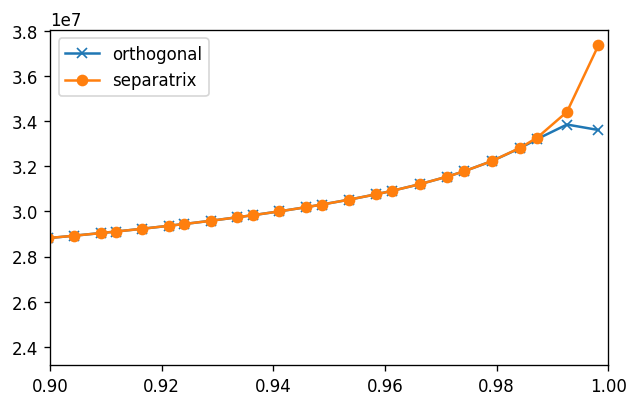

In [12]:
fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
ax.plot( content[0]["rho_t"][0:168], content[0]["dvdpsi"][0:168]#-content2[0]["dvdpsi"][:]
        , marker = 'x', label='orthogonal')
ax.plot( content[0]["rho_t"][0:168], content3[0]["dvdpsi"][0:168]
        , marker = 'o', label='separatrix')
plt.xlim([0.9,1])
plt.legend()
plt.savefig ("dvdpsi-orthogonal-separatrix.png",bbox_inches='tight')
plt.show()

Depending on how exactly we compute the flux surface average we obtain different results

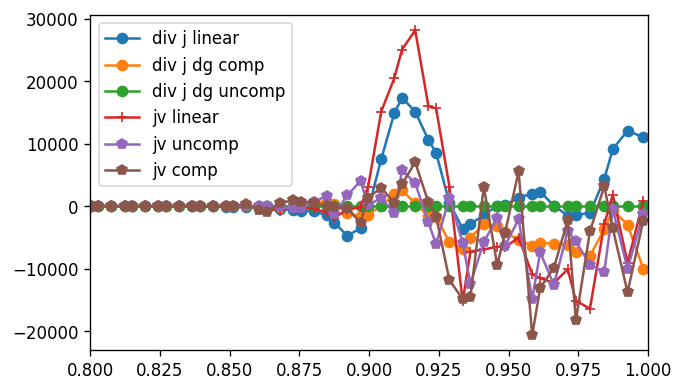

In [24]:

fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
tau = 1
res = 1e-4
reference = (content3[0]["file"]["divneuE_tt_ifs"][30,0:168]
             -content3[0]["file"]["divniuE_tt_ifs"][30,0:168])

ax.plot( content[0]["rho_t"][0:168],
         content2[0]["file"]["divneuE_tt_ifs"][30,0:168]
        -content2[0]["file"]["divniuE_tt_ifs"][30,0:168] -reference
        , marker = 'o', label='div j linear'
       )
ax.plot( content[0]["rho_t"][0:168],
         content3[1]["file"]["divneuE_tt_ifs"][30,0:168]
        -content3[1]["file"]["divniuE_tt_ifs"][30,0:168]-reference
        , marker = 'o', label='div j dg comp'
       )
ax.plot( content[0]["rho_t"][0:168],
         content3[0]["file"]["divneuE_tt_ifs"][30,0:168]
        -content3[0]["file"]["divniuE_tt_ifs"][30,0:168]-reference
        , marker = 'o', label='div j dg uncomp'
       )
# ax.plot( content[0]["rho_t"][0:168],
#          content[1]["file"]["jvneE_tt_ifs"][38,0:168]#/content3[1]["dvdpsi"][0:168]
#         -content[1]["file"]["jvniE_tt_ifs"][38,0:168]#/content3[1]["dvdpsi"][0:168]
#         , marker = 'x', label='orthogonal jv')
ax.plot( content[0]["rho_t"][0:168],
        content2[0]["file"]["jvneE_tt_fsa"][30,0:168]#/content3[1]["dvdpsi"][0:168]
        -content2[0]["file"]["jvniE_tt_fsa"][30,0:168] - reference#/content3[1]["dvdpsi"][0:168]
        , marker = '+',label='jv linear')

ax.plot( content[0]["rho_t"][0:168],
        content3[0]["file"]["jvneE_tt_fsa"][30,0:168]#/content3[1]["dvdpsi"][0:168]
        -content3[0]["file"]["jvniE_tt_fsa"][30,0:168]-reference#/content3[1]["dvdpsi"][0:168]
        , marker = 'p',label='jv uncomp')
ax.plot( content[0]["rho_t"][0:168],
        content3[1]["file"]["jvneE_tt_fsa"][30,0:168]#/content3[1]["dvdpsi"][0:168]
        -content3[1]["file"]["jvniE_tt_fsa"][30,0:168]-reference#/content3[1]["dvdpsi"][0:168]
        , marker = 'p',label='jv comp')
plt.legend(loc = 'upper left')
plt.xlim([0.8,1.0])
plt.savefig("various-ExB-fsa-methods.png",bbox_inches='tight')
plt.show()

The problem is also the derivative of the FSA

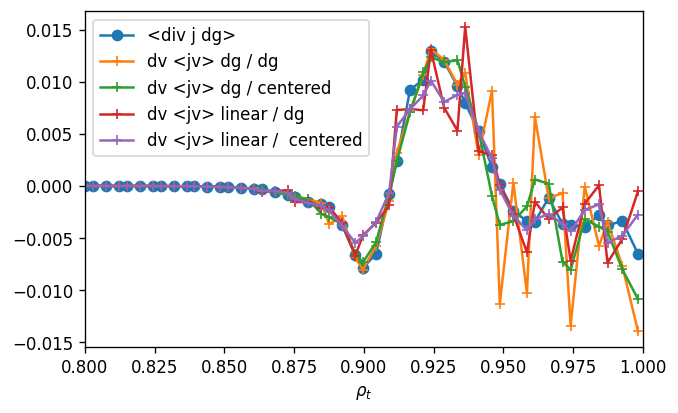

In [36]:

fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')

# ax.plot( content[0]["rho_t"][:],
#          content[1]["file"]["jvneE_tt_ifs"][30,:]#/content3[1]["dvdpsi"][:]
#         -content[1]["file"]["jvniE_tt_ifs"][30,:]#/content3[1]["dvdpsi"][:]
#         , marker = 'x', label='orthogonal jv')
ax.plot( content[0]["rho_t"][0:168],
         content[0]["file"]["divneuE_tt_fsa"][30,0:168]
        -content[0]["file"]["divniuE_tt_fsa"][30,0:168]
        , marker = 'o', label='<div j dg>'
       )
ax.plot( content[0]["rho_t"][0:168],
         content[0]["file"]["jvneE_tt_ifs"][30,0:168]#/content3[1]["dvdpsi"][:]
        -content[0]["file"]["jvniE_tt_ifs"][30,0:168]#/content3[1]["dvdpsi"][:]
        , marker = '+',label='dv <jv> dg / dg')
deriv = centered_derivative_alt( content[0]["volume"][0:168], 
         content[0]["file"]["jvneE_tt_fsa"][30,0:168]#/content3[1]["dvdpsi"][:]
        -content[0]["file"]["jvniE_tt_fsa"][30,0:168]#/content3[1]["dvdpsi"][:])
                  , content[0]['rho_p'][0:168]         )
ax.plot( content[0]["rho_t"][0:168],deriv
        , marker = '+',label='dv <jv> dg / centered')

ax.plot( content[0]["rho_t"][0:168],
         content2[0]["file"]["jvneE_tt_ifs"][30,0:168]#/content3[1]["dvdpsi"][0:168]
        -content2[0]["file"]["jvniE_tt_ifs"][30,0:168]#/content3[1]["dvdpsi"][0:168]
        , marker = '+',label='dv <jv> linear / dg')
deriv = centered_derivative( content[0]["volume"][0:168], 
         content2[0]["file"]["jvneE_tt_fsa"][30,0:168]#/content3[1]["dvdpsi"][:]
        -content2[0]["file"]["jvniE_tt_fsa"][30,0:168]#/content3[1]["dvdpsi"][:])
                  ,content[0]['rho_p'][0:168] 
                                  )
ax.plot( content[0]["rho_t"][0:168],deriv
        , marker = '+',label='dv <jv> linear /  centered')
plt.legend(loc='upper left')
plt.xlim([0.8,1.0])
plt.xlabel(r"$\rho_t$")
plt.savefig("various-ExB-derivative-methods.png", bbox_inches='tight' )
plt.show()

This will generate problems when comparing quantities on the LCFS

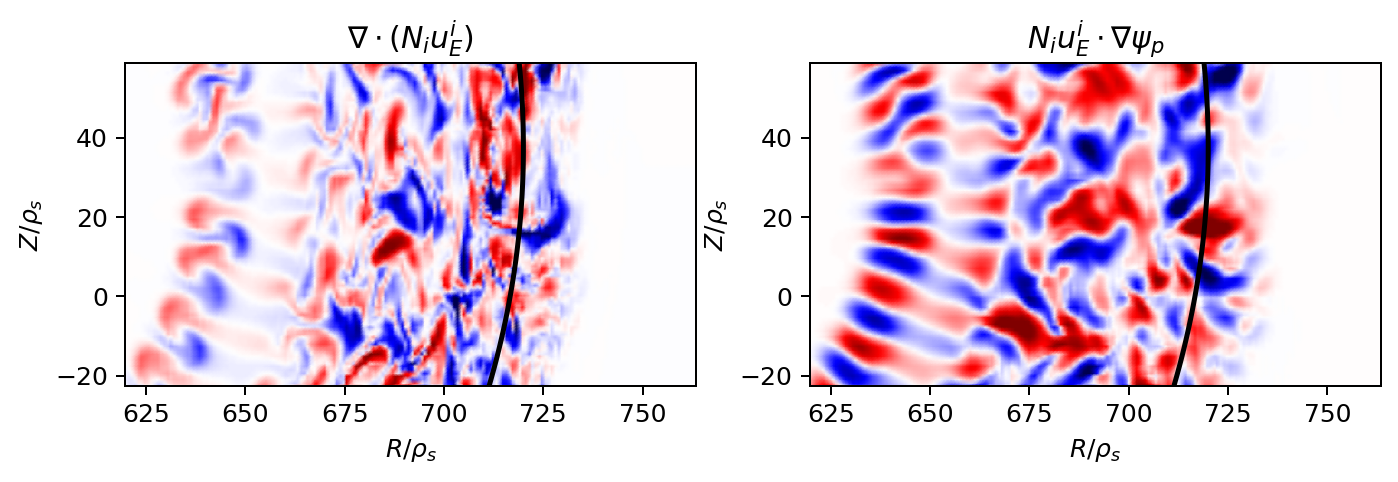

In [91]:
da = Dataset( data.outfile(data.table()[3]),'r')
fig,ax=plt.subplots(1,2,figsize=(3*3,3*3.7),dpi= 180, facecolor='w', edgecolor='k')

last_idx = np.size( da["time"])-1
# cmap=plt.get_cmap('twilight_shifted')
pcm = ax[0].pcolormesh( da['x'][400:], da['y'][500:600],
                    da['divniuE_tt_2d'][last_idx,500:600,400:],
                       vmin=-1,vmax=1,
                shading='gouraud',
                cmap="seismic",
              rasterized=True)
ax[0].set_aspect('equal')
ax[0].set_xlabel( r"$R/\rho_s$")
ax[0].set_ylabel( r"$Z/\rho_s$")
ax[0].set_title( r"$\nabla \cdot( N_i u_E^i)$")
im = ax[0].contour( da['x'][400:], da['y'][500:600], da["Rho_p"][500:600,400:],
                levels=[1], linewidths=2,colors='k')
pcm = ax[1].pcolormesh( da['x'][400:], da['y'][500:600],
                    da['jsniE_tt_2d'][last_idx,500:600,400:],vmin=-5,vmax=5,
                shading='gouraud',
                cmap="seismic",
              rasterized=True)
ax[1].set_aspect('equal')
ax[1].set_xlabel( r"$R/\rho_s$")
ax[1].set_ylabel( r"$Z/\rho_s$")
ax[1].set_title( r"$N_i u_E^i\cdot \nabla\psi_p$")
im = ax[1].contour( da['x'][400:], da['y'][500:600], da["Rho_p"][500:600,400:],
                levels=[1], linewidths=2,colors='k')
plt.savefig( 'jsni_2d.png',bbox_inches='tight')
plt.show()

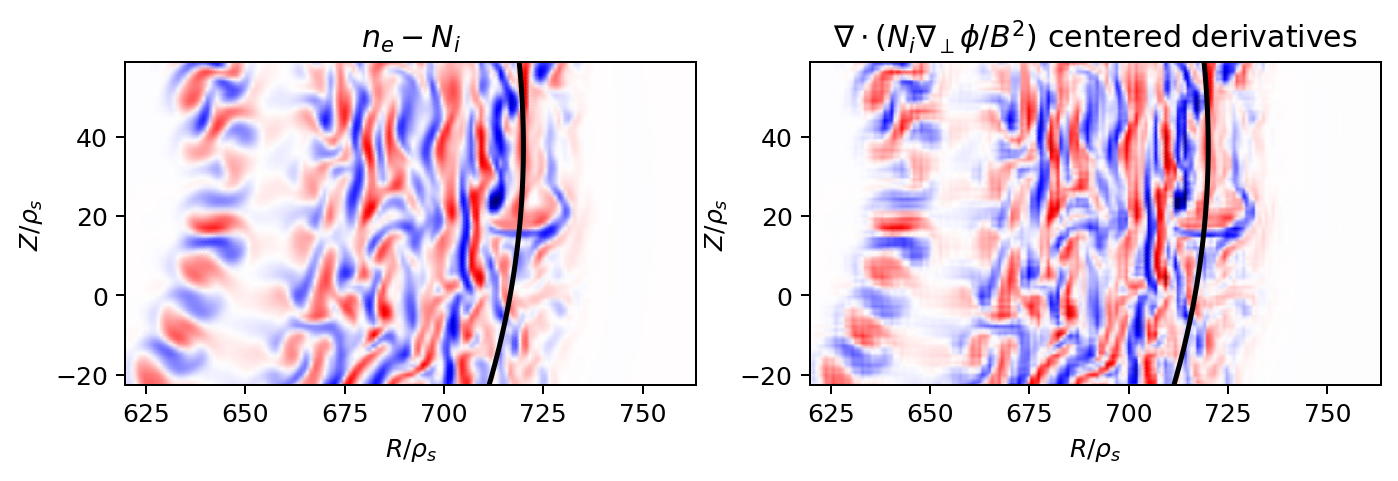

In [92]:
da = Dataset( data.outfile(data.table()[3]),'r')
fig,ax=plt.subplots(1,2,figsize=(3*3,3*3.7),dpi= 180, facecolor='w', edgecolor='k')

last_idx = np.size( da["time"])-1
# cmap=plt.get_cmap('twilight_shifted')
pcm = ax[0].pcolormesh( da['x'][400:], da['y'][500:600],
                    da['electrons_2d'][last_idx,500:600,400:]-da['ions_2d'][last_idx,500:600,400:],
                       vmin=-0.3,vmax=0.3,
                shading='gouraud',
                cmap="seismic",
              rasterized=True)
im = ax[0].contour( da['x'][400:], da['y'][500:600], da["Rho_p"][500:600,400:],
                levels=[1], linewidths=2,colors='k')
ax[0].set_aspect('equal')
ax[0].set_xlabel( r"$R/\rho_s$")
ax[0].set_ylabel( r"$Z/\rho_s$")
ax[0].set_title(r"$n_e - N_i$")
pcm = ax[1].pcolormesh( da['x'][400:], da['y'][500:600],
                    da['v_Omega_E_gf_2d'][last_idx,500:600,400:],vmin=-0.3,vmax=0.3,
                shading='gouraud',
                cmap="seismic",
              rasterized=True)
ax[1].set_aspect('equal')
ax[1].set_xlabel( r"$R/\rho_s$")
ax[1].set_ylabel( r"$Z/\rho_s$")
ax[1].set_title(r"$\nabla\cdot ( N_i \nabla_\perp \phi/B^2)$ centered derivatives")
im = ax[1].contour( da['x'][400:], da['y'][500:600], da["Rho_p"][500:600,400:],
                levels=[1], linewidths=2,colors='k')
plt.savefig( 'centered-derivative-elliptic-2d.png',bbox_inches='tight')
plt.show()

In [93]:
rhs = da['electrons_2d'][last_idx,:,:]-da['ions_2d'][last_idx,:,:]
error = (rhs -  da['v_Omega_E_gf_2d'][last_idx,:,:])
norm_error = np.sqrt(np.sum( error*da['vol2d']*error))
norm_b = np.sqrt(np.sum( rhs*da['vol2d']*rhs))
print(f"Relative error {norm_error/norm_b:0.2f}")

Relative error 0.33


[1, 1]


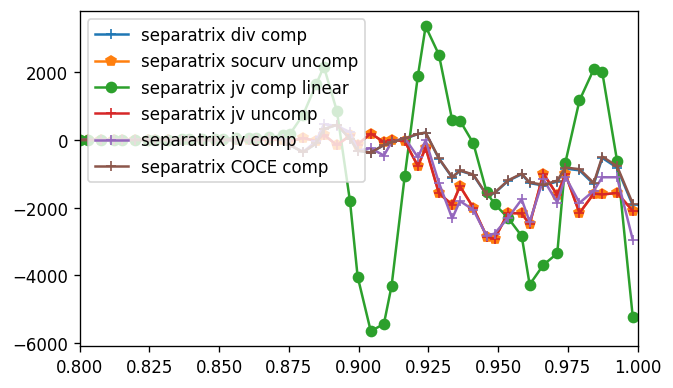

In [14]:

print( content[0]["output"]["compression"])
# for tau in [0,1]:
fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
tau = 1
res = 1e-4
reference = (content3[0]["file"]["divcurvne_tt_ifs"][30,0:168]
        +content3[0]["file"]["divcurvkappane_tt_ifs"][30,0:168]
        -content3[0]["file"]["divcurvni_tt_ifs"][30,0:168]
        -content3[0]["file"]["divcurvkappani_tt_ifs"][30,0:168])

ax.plot( content3[0]["rho_t"][0:168],
         content3[1]["file"]["divcurvne_tt_ifs"][30,0:168]
        +content3[1]["file"]["divcurvkappane_tt_ifs"][30,0:168]
        -content3[1]["file"]["divcurvni_tt_ifs"][30,0:168]
        -content3[1]["file"]["divcurvkappani_tt_ifs"][30,0:168] -reference
        , marker = '+', label='separatrix div comp'
       )
ax.plot( content3[0]["rho_t"][0:168],
         -(content3[0]["file"]["socurve_tt_fsa"][30,0:168]
          +content3[0]["file"]["socurvkappae_tt_fsa"][30,0:168]
          +content3[0]["file"]["socurvi_tt_fsa"][30,0:168]
          +content3[0]["file"]["socurvkappai_tt_fsa"][30,0:168])*content3[0]["dvdpsi"][0:168]-reference
        , marker = 'p', label='separatrix socurv uncomp'
       )
# ax.plot( content[0]["rho_t"][0:168], content[0]["file"]["divcurvne_tt_ifs"][30,0:168]
#         +content[0]["file"]["divcurvkappane_tt_ifs"][30,0:168], marker = '+'
#        )

ax.plot( content2[0]["rho_t"][0:168],
         content2[0]["file"]["jvneC_tt_fsa"][30,0:168]
        -content2[0]["file"]["jvniC_tt_fsa"][30,0:168]-reference, label = 'separatrix jv comp linear',
        marker = 'o')
ax.plot( content3[0]["rho_t"][0:168],
         content3[0]["file"]["jvneC_tt_fsa"][30,0:168]
        -content3[0]["file"]["jvniC_tt_fsa"][30,0:168]-reference, marker = '+',
        label = 'separatrix jv uncomp')
ax.plot( content3[0]["rho_t"][0:168],
         content3[1]["file"]["jvneC_tt_fsa"][30,0:168]
        -content3[1]["file"]["jvniC_tt_fsa"][30,0:168]-reference, marker = '+',
        label = 'separatrix jv comp')
ax.plot( content3[1]["rho_t"][0:168],
        -content3[1]["file"]["v_J_D_gf_tt_ifs"][30,0:168]
        -content3[1]["file"]["v_J_NUK_gf_tt_ifs"][30,0:168]-reference, marker = '+',
        label = 'separatrix COCE comp')
plt.legend(loc='upper left')
plt.xlim([0.8,1.0])
# plt.ylim([-5000,5000])
plt.show()
# content[0]["rho_t"]

[1, 1]


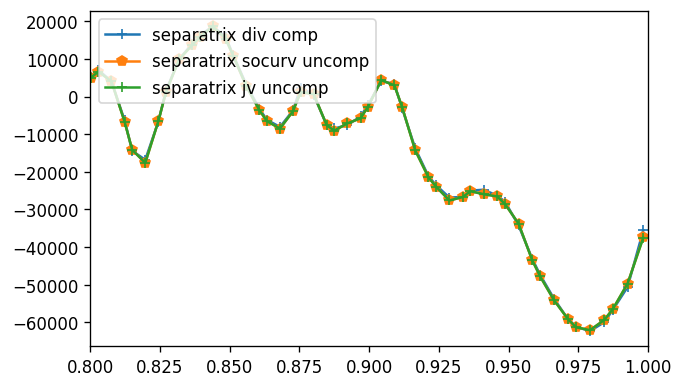

In [15]:

print( content[0]["output"]["compression"])
# for tau in [0,1]:
fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
tau = 1
res = 1e-4
reference = (content[2]["file"]["divcurvne_tt_ifs"][30,0:168]
        +content[3]["file"]["divcurvkappane_tt_ifs"][30,0:168]
        -content[3]["file"]["divcurvni_tt_ifs"][30,0:168]
        -content[3]["file"]["divcurvkappani_tt_ifs"][30,0:168])*0

ax.plot( content[3]["rho_t"][0:168],
         content[3]["file"]["divcurvne_tt_ifs"][30,0:168]
        +content[3]["file"]["divcurvkappane_tt_ifs"][30,0:168]
        -content[3]["file"]["divcurvni_tt_ifs"][30,0:168]
        -content[3]["file"]["divcurvkappani_tt_ifs"][30,0:168] -reference
        , marker = '+', label='separatrix div comp'
       )
ax.plot( content[3]["rho_t"][0:168],
         -(content[3]["file"]["socurve_tt_fsa"][30,0:168]
          +content[3]["file"]["socurvkappae_tt_fsa"][30,0:168]
          +content[3]["file"]["socurvi_tt_fsa"][30,0:168]
          +content[3]["file"]["socurvkappai_tt_fsa"][30,0:168])*content3[0]["dvdpsi"][0:168]-reference
        , marker = 'p', label='separatrix socurv uncomp'
       )
ax.plot( content[3]["rho_t"][0:168],
         content[3]["file"]["jvneC_tt_fsa"][30,0:168]
        -content[3]["file"]["jvniC_tt_fsa"][30,0:168]-reference, marker = '+',
        label = 'separatrix jv uncomp')

plt.legend(loc='upper left')
plt.xlim([0.8,1.0])
# plt.ylim([-5000,5000])
plt.show()
# content[0]["rho_t"]

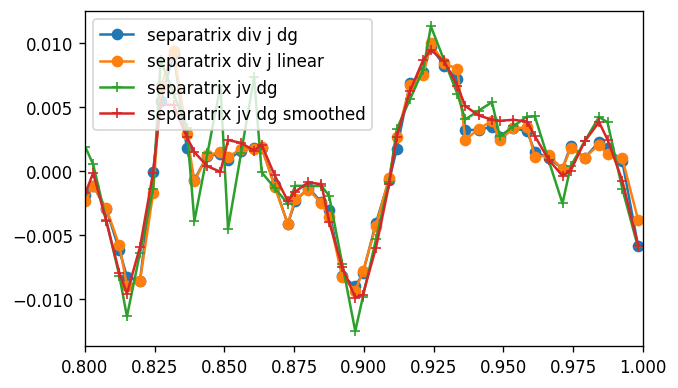

In [28]:

fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
tau = 1
res = 1e-4
reference = (content[2]["file"]["divneuE_tt_fsa"][30,0:168]
             -content[2]["file"]["divniuE_tt_fsa"][30,0:168])

ax.plot( content[2]["rho_t"][0:168],
         content[2]["file"]["divneuE_tt_fsa"][30,0:168]
        -content[2]["file"]["divniuE_tt_fsa"][30,0:168]# -reference
        , marker = 'o', label='separatrix div j dg'
       )
ax.plot( content2[1]["rho_t"][0:168],
         content2[1]["file"]["divneuE_tt_fsa"][30,0:168]
        -content2[1]["file"]["divniuE_tt_fsa"][30,0:168]# -reference
        , marker = 'o', label='separatrix div j linear'
       )
# ax.plot( content[0]["rho_t"][0:168],
#          content[1]["file"]["jvneE_tt_ifs"][38,:]#/content3[1]["dvdpsi"][0:168]
#         -content[1]["file"]["jvniE_tt_ifs"][38,:]#/content3[1]["dvdpsi"][0:168]
#         , marker = 'x', label='orthogonal jv')
from scipy.signal import savgol_filter
## !! Attention savgol uses equidistant values
y = (content[2]["file"]["jvneE_tt_ifs"][30,0:168]#/content3[1]["dvdpsi"][0:168]
   -content[2]["file"]["jvniE_tt_ifs"][30,0:168])#
yhat = savgol_filter(y, 7, 2) # window size 51, polynomial order 3

ax.plot( content[2]["rho_t"][0:168],y, marker = '+',label='separatrix jv dg')
ax.plot( content[2]["rho_t"][0:168],yhat, marker = '+',label='separatrix jv dg smoothed')

plt.legend(loc = 'upper left')
plt.xlim([0.8,1.0])
plt.show()

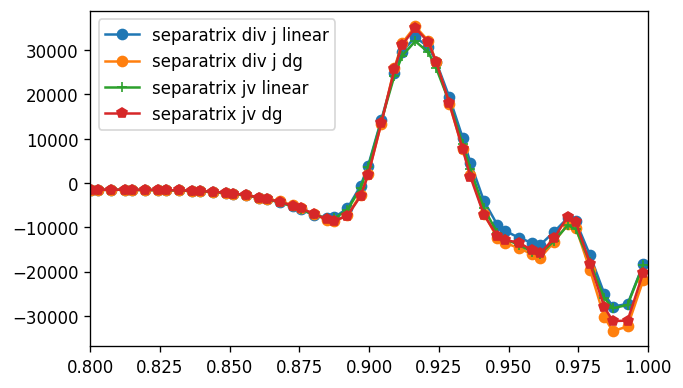

In [56]:

fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
tau = 1
res = 1e-4

ax.plot( content[0]["rho_t"][0:168],
         content2[0]["file"]["divneuA_tt_ifs"][30,0:168]
        -content2[0]["file"]["divniuA_tt_ifs"][30,0:168]
        , marker = 'o', label='separatrix div j linear'
       )
ax.plot( content[0]["rho_t"][0:168],
         content3[1]["file"]["divneuA_tt_ifs"][30,0:168]
        -content3[1]["file"]["divniuA_tt_ifs"][30,0:168]
        , marker = 'o', label='separatrix div j dg'
       )
ax.plot( content[0]["rho_t"][0:168],
        content2[0]["file"]["jvneA_tt_fsa"][30,0:168]#/content3[1]["dvdpsi"][0:168]
        -content2[0]["file"]["jvniA_tt_fsa"][30,0:168]#/content3[1]["dvdpsi"][0:168]
        , marker = '+',label='separatrix jv linear')

ax.plot( content[0]["rho_t"][0:168],
        content3[1]["file"]["jvneA_tt_fsa"][30,0:168]#/content3[1]["dvdpsi"][0:168]
        -content3[1]["file"]["jvniA_tt_fsa"][30,0:168]#/content3[1]["dvdpsi"][0:168]
        , marker = 'p',label='separatrix jv dg')
plt.legend()
plt.xlim([0.8,1.0])
plt.show()

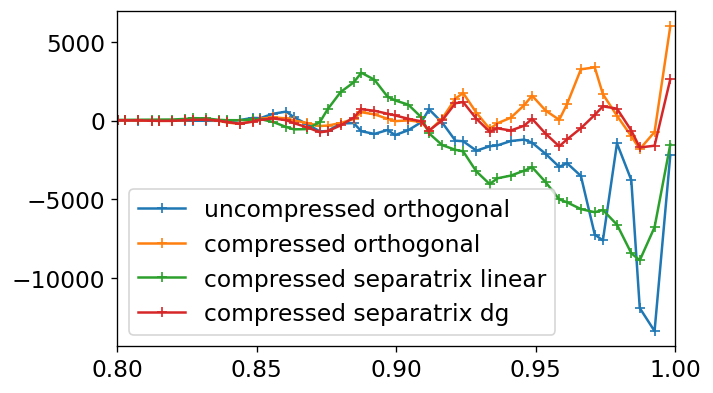

In [322]:

fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
ax.plot( content[0]["rho_t"][0:168],
         content[0]["file"]["divjnepar_tt_ifs"][37,0:168]
        -content[0]["file"]["divjnipar_tt_ifs"][37,0:168]
        , marker = '+', label='uncompressed orthogonal'
       )
ax.plot( content[0]["rho_t"][0:168],
         content[1]["file"]["divjnepar_tt_ifs"][37,0:168]
        -content[1]["file"]["divjnipar_tt_ifs"][37,0:168]
        , marker = '+', label='compressed orthogonal'
       )
ax.plot( content2[0]["rho_t"][0:168],
         content2[0]["file"]["divjnepar_tt_ifs"][37,0:168]
        -content2[0]["file"]["divjnipar_tt_ifs"][37,0:168]
        , marker = '+', label='compressed separatrix linear'
       )
ax.plot( content3[0]["rho_t"][0:168],
         content3[1]["file"]["divjnepar_tt_ifs"][37,0:168]
        -content3[1]["file"]["divjnipar_tt_ifs"][37,0:168]
        , marker = '+', label='compressed separatrix dg'
       )
plt.legend()
plt.xlim([0.8,1.0])
# plt.ylim([-5000,5000])
plt.show()

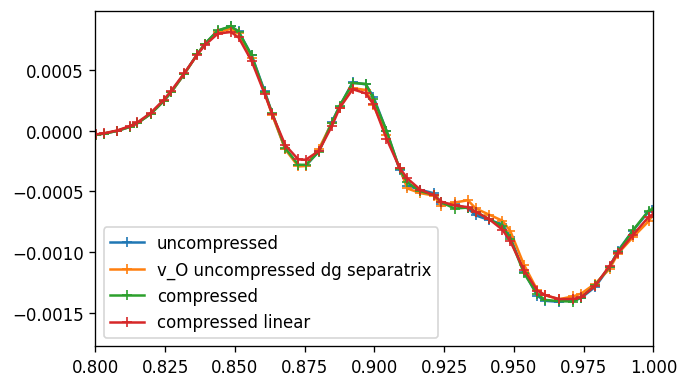

In [44]:

fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
ax.plot( content[0]["rho_t"][:],
         content3[0]["file"]["oexbi_fsa"][37,:]
        -content3[0]["file"]["oexbi_fsa"][36,:]
        , marker = '+', label='uncompressed'
       )
ax.plot( content[0]["rho_t"][:],
         content3[0]["file"]["v_Omega_E_gf_ifs"][37,:]/content3[0]["dvdpsi"][:]
        -content3[0]["file"]["v_Omega_E_gf_ifs"][36,:]/content3[0]["dvdpsi"][:]
        , marker = '+', label='v_O uncompressed dg separatrix'
       )
ax.plot( content[0]["rho_t"][:],
         content3[1]["file"]["oexbi_fsa"][37,:]
        -content3[1]["file"]["oexbi_fsa"][36,:]
        , marker = '+', label='compressed'
       )
ax.plot( content2[0]["rho_t"][:],
         content2[0]["file"]["oexbi_fsa"][37,:]
        -content2[0]["file"]["oexbi_fsa"][36,:]
        , marker = '+', label='compressed linear'
       )

plt.legend()
plt.xlim([0.8,1.0])
# plt.ylim([-5000,5000])
plt.show()

In [43]:
# to_plot = dict()
# {
#     "tau" : [], # taus
#     "res": {0:[],1:[]} # resistivities for taus
#     "fields" : [ # list of dicts
#     {
#         "color": 0,
#         "label" : r"$\partial_t n_e$",
#         "vals": {0:{res: [], ...},1:{...}}, # time series for tau = 0 and tau = 1 and various resistivities
#     }
#     ]
# }
def plot_relative( to_plot, ax, tau, style):  
    """Compute mean and error of several terms described in to_plot as a function of resistivity
    on given axis ax, for given tau
    """
    resistivities = np.array(sorted(to_plot["res"][tau]))
    size = resistivities.size
    mean=dict()
    std = dict()
    
    for field in to_plot["fields"]:
        mean[field["label"]]=np.zeros(size)
        std[field["label"]]=np.zeros(size)
        for i in np.arange(0,size,1):  
            min_idx = min_idx_dict[tau][resistivities[i]]
            mean[field["label"]][i] = field["vals"][tau][resistivities[i]][min_idx:].mean()
            std[field["label"]][i] = field["vals"][tau][resistivities[i]][min_idx:].std()
#         print( "Averages ", field["label"], " is ", mean[field["label"]])
    error = list()
    mean_error = np.zeros(size)
    std_error = np.zeros(size)
    for i in np.arange(0,size,1):   
        min_idx = min_idx_dict[tau][resistivities[i]]
        error.append(np.zeros( len(to_plot["times"][tau][resistivities[i]][min_idx:])))
        for field in to_plot["fields"]:
            error[i] = error[i] + field["vals"][tau][resistivities[i]][min_idx:]
        mean_error[i] = error[i].mean()
        std_error[i] = error[i].std()

    summe = np.abs(mean_error)
    for field in to_plot["fields"]:
        summe = summe + np.abs(mean[field["label"]])
    if style == "log":
        ax.plot( resistivities, np.abs(mean_error)/summe,
                marker='x', ls='--',label="Error",  color = "r"
               )
        for field in to_plot["fields"]:
            if(mean[field["label"]].mean() != 0):
                ax.plot( resistivities, np.abs(mean[field["label"]])/summe,
            #                  yerr=delta_err[tau],capsize=4
                    marker='x', ls='-',label=field["label"]
                        , color = colors[field["color"]]
                       )
        ax.set_yscale('log')
    elif style == 'linear':
        ax.plot( resistivities, mean_error/summe,
                marker='x', ls='--',label="Error",  color = "r"  )

        ax.fill_between(resistivities, (mean_error-std_error)/summe, (mean_error+std_error)/summe,
                        color='r', alpha=0.2)
        for field in to_plot["fields"]:
            if(mean[field["label"]].mean() != 0):
                ax.plot( resistivities, mean[field["label"]]/summe,
            #                  yerr=delta_err[tau],capsize=4
                    marker='x', ls='-',label=field["label"]
                        , color = colors[field["color"]]
                       )
                ax.fill_between(resistivities, (mean[field["label"]]-std[field["label"]])/summe,
                                (mean[field["label"]]+std[field["label"]])/summe,
                                color = colors[field["color"]],
                        alpha=0.2)
        low, high = ax.get_ylim()
        # find the new limits
        bound = max(abs(low), abs(high))
        # set new limits
        ax.set_ylim(-bound, bound)  
            
            
    ax.set_xlabel(r'$\eta$')
    ax.set_ylabel('relative importance')
    ax.set_xscale('log')    

In [170]:
def plot_series( to_plot, ax, tau, res, start_idx=1):   
    """Plot several terms described in to_plot as a function of time on given axis
    for given tau and resistivity
    """
    mean=dict()
    std = dict()
#     min_idx = min_idx_dict[tau][res]
    for field in to_plot["fields"]:
        mean[field["label"]] = field["vals"][tau][res][start_idx:].mean()
        std[field["label"]]  = field["vals"][tau][res][start_idx:].std()
#         print( "Averages ", field["label"], " is ", mean[field["label"]])
    error = np.zeros( len(to_plot["times"][tau][res]))
    for field in to_plot["fields"]:
        error = error + field["vals"][tau][res]
    mean_error = error[start_idx:].mean()
    std_error = error[start_idx:].std()
    print( "Mean error is ", mean_error, " std error is ", std_error)

    ax.plot( to_plot["times"][tau][res][start_idx:], error[start_idx:],
            ls='--',label="Error",  color = "r"
           )
    for field in to_plot["fields"]:
        ax.plot( to_plot["times"][tau][res][start_idx:], field["vals"][tau][res][start_idx:],
    #                  yerr=delta_err[tau],capsize=4
            ls='-',label=field["label"]
                , color = colors[field["color"]]
               )
#         ax.hlines(mean[field['label']], to_plot["times"][tau][res][min_idx],
#                   to_plot["times"][tau][res][-1], color=colors[field["color"]])
#         ax.fill_between( to_plot["times"][tau][res][min_idx:],
#                         (mean[field['label']]-std[field['label']]),
#                         (mean[field['label']]+std[field['label']]),
#                         color=colors[field["color"]], alpha=0.2)

    ax.hlines(mean_error, to_plot["times"][tau][res][start_idx],
              to_plot["times"][tau][res][-1], color='r')
    ax.fill_between( to_plot["times"][tau][res][start_idx:],
                    (mean_error-std_error), (mean_error+std_error),
                    color='red', alpha=0.2)
    ax.set_xlabel(r'$t$ / $\Omega_0^{-1}$')
    ax.set_ylabel(r'$\int_0^{v(1)} \langle t_i(R,Z,\varphi,t)\rangle dv$')
    # get y-axis limits of the plot
    low, high = ax.get_ylim()
    # find the new limits
    bound = max(abs(low), abs(high))
    # set new limits
    ax.set_ylim(-bound, bound)

In [45]:
def make_to_plot( to_plot, in_content):
    """Fill in values in the to_plot dictionary"""
    for pp in in_content :
        da = pp['file']
        time = np.asarray(da['time'][:])
        deltat = np.diff(np.append(time, 2*time[-1] -time[-2]))
        tau = pp["physical"]["tau"]
        res = pp["physical"]["resistivity"]
        to_plot["res"][tau].append(res)
        to_plot["times"][tau][res] = time
        to_plot["params"][tau][res] = pp 
        for field in to_plot["fields"]:
            series = np.zeros(len(time))
            for (name,sign,derive) in zip(field["names"],field["signs"],field['derive']):
                addition = np.zeros(len(time))
#                 print(field)
                if "idx" in field.keys():
                    addition = np.asarray(da[name][:,field["idx"]])*sign
                else:
                    addition = np.asarray(da[name][:])*sign
                if derive:
                    addition = np.diff(np.append(np.zeros(1),addition, axis=0))#/deltat
                series = series + addition
            field["vals"][tau][res] = series

In [46]:
### THE TERMS IN THE DENSITY CONSERVATION
idx = 167
to_plot_mass = {
    "tau" : [1], # taus
    "res": {0:[],1:[]}, # resistivities for taus
    "times": {0:dict(),1:dict()},
    "params" : {0:dict(),1:dict()}, # a copy of all parameters
    "fields" : [ # list of dicts
    {
#         "names" : ["electrons_ifs","sne_tt_ifs","divneuE_tt_ifs","divcurvne_tt_ifs"],"idx":idx,
        "names" : ["ions_ifs","sni_tt_ifs","divniuE_tt_ifs","divcurvni_tt_ifs"], "idx":idx,
        "derive" : [True,False,False,False], "signs" : [+1,-1,+1,+1],
        "color": 0,
        "label" : r"$\partial_t (n_e) - S_e + j_E + j_K$",
        "vals": {0:dict(),1:dict()},
    },

    {
#         "names" : ['divneuA_tt_ifs'], "idx":idx, "derive" : [False], "signs" : [+1],
        "names" : ['divniuA_tt_ifs'], "idx":idx, "derive" : [False], "signs" : [+1],
        "color": 1,
        "label" : r"$\nabla\cdot\vec{ j_A}$",
        "vals": {0:dict(),1:dict()},
    },
#     {
#         "names" : ['jvneC_tt_ifs_lcfs'], "derive" : [False], "signs" : [+1],
#         "names" : ['jvniC_tt_ifs_lcfs'], "derive" : [False], "signs" : [+1],
#         "color": 2,
#         "label" : r"$\nabla\cdot\vec{ j_C}$",
#         "vals": {0:dict(),1:dict()},
#     },
    {
        "names" : ['divcurvkappani_tt_ifs' ], "idx":idx,
#         "names" : ['divcurvkappane_tt_ifs' ], "idx":idx,
        "derive" : [False], "signs" : [+1],
        "color":3,
        "label" : r"$\nabla\cdot\vec{ j_{kappa}}$",
        "vals": {0:dict(),1:dict()},
    },
#     {
#         "names" : ['divcurvne_tt_ifs' ], "idx":idx,
# #         "names" : ['divcurvni_tt_ifs' ], "idx":idx,
#         "derive" : [False], "signs" : [+1],
#         "color":4,
#         "label" : r"$\nabla\cdot\vec{ j_{curv}}$",
#         "vals": {0:dict(),1:dict()},
#     },
    {
#         "names" : ['divjnepar_tt_ifs'], "idx":idx, "derive" : [False], "signs" : [+1],
        "names" : ['divjnipar_tt_ifs'], "idx":idx, "derive" : [False], "signs" : [+1],
        "color": 5,
        "label" : r"$\nabla\cdot\vec{ j_\parallel}$",
        "vals": {0:dict(),1:dict()},
    },
    { 
#         "names" : ['lneperp_tt_ifs'], "idx":idx, "derive" : [False], "signs" : [-1],
        "names" : ['lniperp_tt_ifs'], "idx":idx, "derive" : [False], "signs" : [-1],
        "color": 6,
        "label" : r"$\Delta_\perp$",
        "vals": {0:dict(),1:dict()},
    },
    {
#         "names" : ['lneparallel_tt_ifs'], "idx":idx, "derive" : [False], "signs" : [-1],
        "names" : ['lniparallel_tt_ifs'], "idx":idx, "derive" : [False], "signs" : [-1],
        "color": 7,
        "label" : r"$\Delta_\parallel$",
        "vals": {0:dict(),1:dict()},
    },

    ]
}



Mean error is  19795.970229011542  std error is  12195.975777937807


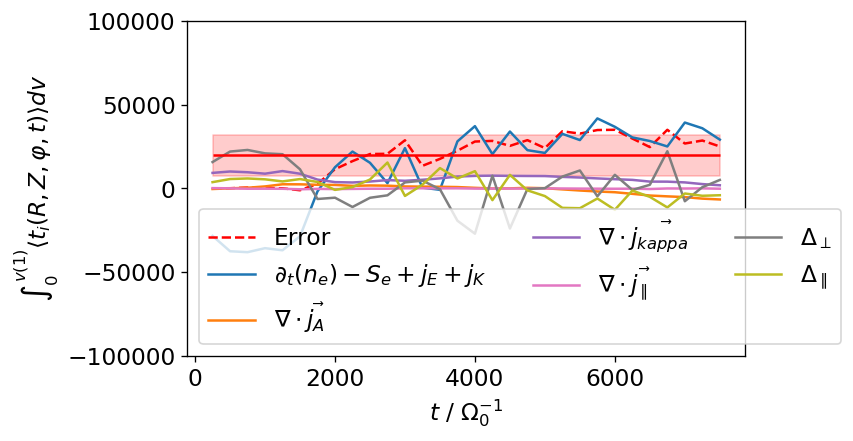

Mean error is  -1174.0231820027814  std error is  3916.2909868116017


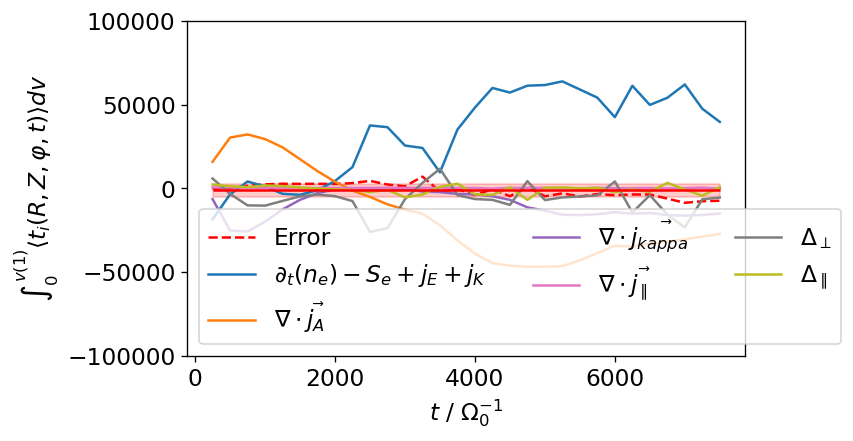

In [60]:
# content_nn = [content2[1],content2[2]]
content_nn = [content[2],content[5]]
# print( content[2]["output"]["compression"], content[2]["physical"]["tau"])
make_to_plot(to_plot_mass,content_nn)
# for tau in [0,1]:
fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
tau = 0
res = 1e-4
plot_series(to_plot_mass,ax,tau,res)

plt.legend(ncol=3,loc='lower left')
plt.ylim([-100000, 100000])
plt.show()
# print( content[3]["output"]["compression"], content[3]["physical"]["tau"])

# for tau in [0,1]:
fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
tau = 1
res = 1e-4
plot_series(to_plot_mass,ax,tau,res)

plt.legend(ncol=3,loc='lower left')
plt.ylim([-100000, 100000])
plt.show()

In [251]:
### THE TERMS IN THE VORTICITY/DENSITY DIFF CONSERVATION
to_plot_mass_diff = {
    "tau" : [1], # taus
    "res": {0:[],1:[]}, # resistivities for taus
    "times": {0:dict(),1:dict()},
    "params" : {0:dict(),1:dict()}, # a copy of all parameters
    "fields" : [ # list of dicts
    {
        "names" : ["electrons_ifs_lcfs","ions_ifs_lcfs"], "derive" : [True,True], "signs" : [+1,-1],
        "color": 0,
        "label" : r"$\partial_t (n_e-N_i)$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['jvneE_tt_ifs_lcfs','jvniE_tt_ifs_lcfs'], "derive" : [False,False], "signs" : [+1,-1],
#         "names" : ['divneuE_tt_ifs_lcfs','divniuE_tt_ifs_lcfs'], "derive" : [False,False], "signs" : [+1,-1],
        "color": 6,
        "label" : r"$\nabla\cdot\vec{ j_E}$",
        "vals": {0:dict(),1:dict()},
    },
    {
#         "names" : ['jvneA_tt_ifs_lcfs','jvniA_tt_ifs_lcfs'], "derive" : [False,False], "signs" : [+1,-1],
        "names" : ['divneuA_tt_ifs_lcfs','divniuA_tt_ifs_lcfs'], "derive" : [False,False], "signs" : [+1,-1],
        "color": 8,
        "label" : r"$\nabla\cdot\vec{ j_A}$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['jvneC_tt_ifs_lcfs','jvniC_tt_ifs_lcfs'], "derive" : [False,False], "signs" : [+1,-1],
        "color": 2,
        "label" : r"$\nabla\cdot\vec{ j_C}$",
        "vals": {0:dict(),1:dict()},
    },
#     {
#         "names" : ['divcurvkappane_tt_ifs_lcfs','divcurvkappani_tt_ifs_lcfs'],
#         "derive" : False, "signs" : [+1,-1],
#         "color":6,
#         "label" : r"$\nabla\cdot\vec{ j_k}$",
#         "vals": {0:dict(),1:dict()},
#     },
#     {
#         "names" : ['divcurvkappane_tt_ifs_lcfs','divcurvkappani_tt_ifs_lcfs',
#                    'divcurvne_tt_ifs_lcfs','divcurvni_tt_ifs_lcfs' ],
#         "derive" : False, "signs" : [+1,-1,+1,-1],
#         "color":7,
#         "label" : r"$\nabla\cdot\vec{ j_C}$",
#         "vals": {0:dict(),1:dict()},
#     },
#     {
#         "names" : ['v_J_D_gf_tt_ifs_lcfs' ],
#         "derive" : False, "signs" : [-1],
#         "color":8,
#         "label" : r"$\nabla\cdot\vec{ j_C}$",
#         "vals": {0:dict(),1:dict()},
#     },
    {
        "names" : ['divjnepar_tt_ifs_lcfs','divjnipar_tt_ifs_lcfs'], "derive" : [False,False], "signs" : [+1,-1],
        "color": 3,
        "label" : r"$\nabla\cdot\vec{ j_\parallel}$",
        "vals": {0:dict(),1:dict()},
    },
#     { # 1e-6 for both 
#         "names" : ['sne_tt_ifs_lcfs','sni_tt_ifs_lcfs'], "derive" : [False,False], "signs" : [-1,+1],
#         "color": 4,
#         "label" : r"$S$",
#         "vals": {0:dict(),1:dict()},
#     },
    { # lniperp has a mistake
        "names" : ['lneperp_tt_ifs_lcfs','lniperp_tt_ifs_lcfs'], "derive" : [False,False], "signs" : [-1,+1],
#         "names" : ['loexbe_tt_ifs_lcfs'], "derive" : False, "signs" : [-1],
        "color": 5,
        "label" : r"$\Delta_\perp$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['lneparallel_tt_ifs_lcfs','lniparallel_tt_ifs_lcfs'], "derive" : [False,False], "signs" : [-1,+1],
        "color": 7,
        "label" : r"$\Delta_\parallel$",
        "vals": {0:dict(),1:dict()},
    },

    ]
}



Mean error is  -17838.913266156822  std error is  16640.101039556743


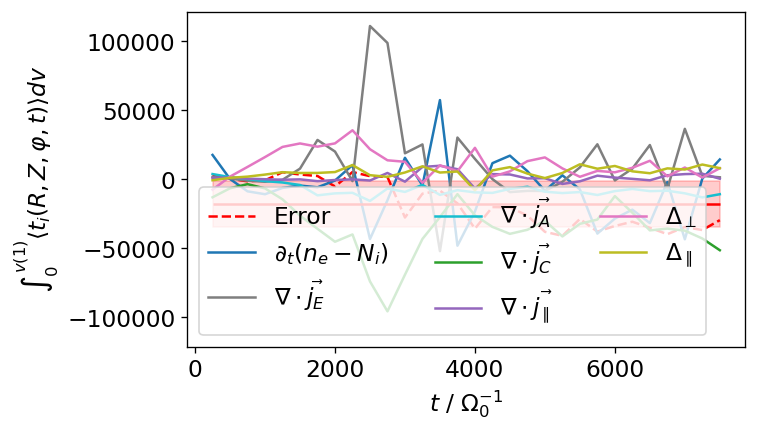

Mean error is  -10502.353003902712  std error is  14072.476906347212


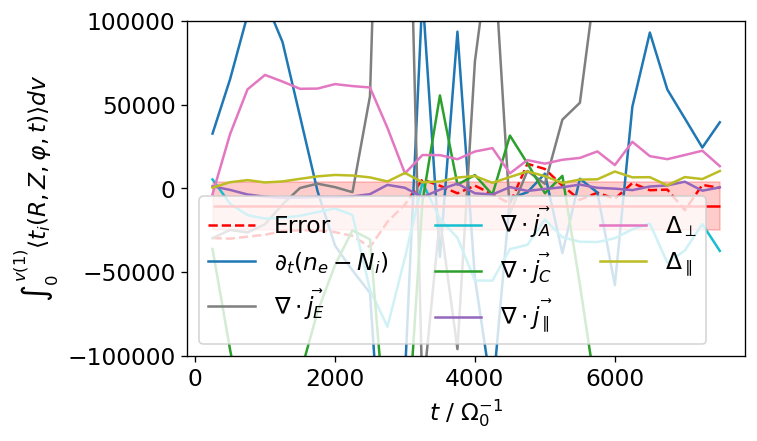

In [252]:
content_nn = [content[2],content[5]]
# content_nn = [content[2],content[3]]
# print( content[2]["output"]["compression"], content[2]["physical"]["tau"])
make_to_plot(to_plot_mass_diff,content_nn)
# for tau in [0,1]:
fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
tau = 0
res = 1e-4
plot_series(to_plot_mass_diff,ax,tau,res)

plt.legend(ncol=3,loc='lower left')
plt.show()
# print( content[3]["output"]["compression"], content[3]["physical"]["tau"])

# for tau in [0,1]:
fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
tau = 1
res = 1e-4
plot_series(to_plot_mass_diff,ax,tau,res)

plt.legend(ncol=3,loc='lower left')
plt.ylim([-100000, 100000])
plt.show()

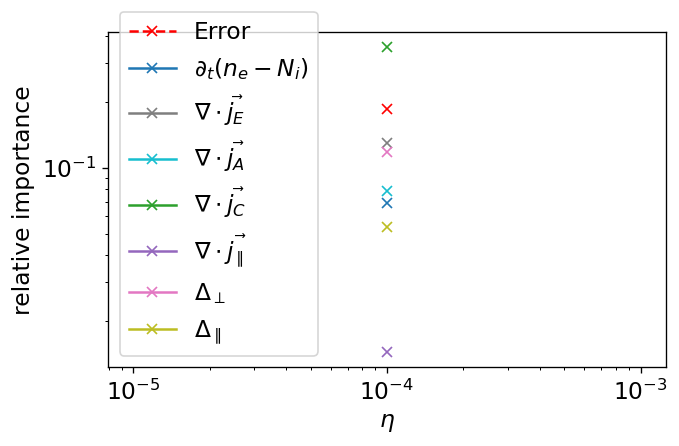

In [253]:
# content_nn = [content[2]]
# make_to_plot(to_plot_mass_diff,content_nn)
# more diffusion needed for tau=1 simulations?
# n_e - N_i not relevant for tau = 1 simulations?
for tau in [0]:
    fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
    plot_relative(to_plot_mass_diff,ax,tau,'log')
#     ax.set_yscale("linear")
    plt.legend(ncol=1,loc='lower left')
#     plt.ylim([1e-4,1])
#     plt.savefig( 'neni-diff-importance-'+str(tau)+'.png',bbox_inches='tight')
#     plt.show()
# content_nn = [content[1]]
# make_to_plot(to_plot_mass_diff,content_nn)
# # more diffusion needed for tau=1 simulations?
# # n_e - N_i not relevant for tau = 1 simulations?
# for tau in [1]:
# #     fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
#     plot_relative(to_plot_mass_diff,ax,tau,'log')
# #     ax.set_yscale("linear")
# #     plt.legend(ncol=3,loc='lower right')
# #     plt.ylim([1e-6,1])
# #     plt.savefig( 'neni-diff-importance-'+str(tau)+'.png',bbox_inches='tight')
#     plt.show()  

In [77]:
### THE TERMS IN THE COCE CONSERVATION
to_plot_coce = {
    "tau" : [1], # taus
    "res": {0:[],1:[]}, # resistivities for taus
    "times": {0:dict(),1:dict()},
    "params" : {0:dict(),1:dict()}, # a copy of all parameters
    "fields" : [ # list of dicts
    {
        "names" : ["v_Omega_E_gf_ifs_lcfs", "v_Omega_D_gf_ifs_lcfs"], "derive" : [True], "signs" : [+1,+1],
        "color": 0,
        "label" : r"$\partial_t (\Omega)$",
        "vals": {0:dict(),1:dict()},
    },
    {
#         "names" : ['jvneE_tt_ifs_lcfs','jvniE_tt_ifs_lcfs'], "derive" : [False], "signs" : [+1,-1],
        "names" : ['v_adv_E_gf_tt_ifs_lcfs'], "derive" : [False], "signs" : [+1],
        "color": 1,
        "label" : r"$\nabla\cdot\vec{ j_E}$",
        "vals": {0:dict(),1:dict()},
    },
    {
#         "names" : ['jvneE_tt_ifs_lcfs','jvniE_tt_ifs_lcfs'], "derive" : [False], "signs" : [+1,-1],
        "names" : ['v_adv_D_gf_tt_ifs_lcfs'], "derive" : [False], "signs" : [+1],
        "color": 2,
        "label" : r"$\nabla\cdot\vec{ j_D}$",
        "vals": {0:dict(),1:dict()},
    },
    {
#         "names" : ['jvneA_tt_ifs_lcfs','jvniA_tt_ifs_lcfs'], "derive" : [False], "signs" : [+1,-1],
        "names" : ['v_M_em_gf_tt_ifs_lcfs'], "derive" : [False], "signs" : [+1],
        "color": 3,
        "label" : r"$\nabla\cdot\vec{ j_A}$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['v_J_mag_gf_tt_ifs_lcfs'], "derive" : [False], "signs" : [+1],
        "color": 4,
        "label" : r"$\nabla\cdot\vec{ j_{mag}}$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['v_J_bperp_tt_ifs_lcfs'], "derive" : [False], "signs" : [+1],
        "color": 5,
        "label" : r"$\nabla\cdot\vec{ j_{\perp}}$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['v_J_D_gf_tt_ifs_lcfs'],
        "derive" : [False], "signs" : [+1],
        "color":6,
        "label" : r"$\nabla\cdot\vec{ j_C}$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['v_J_par_tt_ifs_lcfs'], "derive" : [False], "signs" : [+1],
        "color": 7,
        "label" : r"$\nabla\cdot\vec{ j_\parallel}$",
        "vals": {0:dict(),1:dict()},
    },

    ]
}

[1, 1]
Mean error is  -11067.776097166648  std error is  64857.513557107945


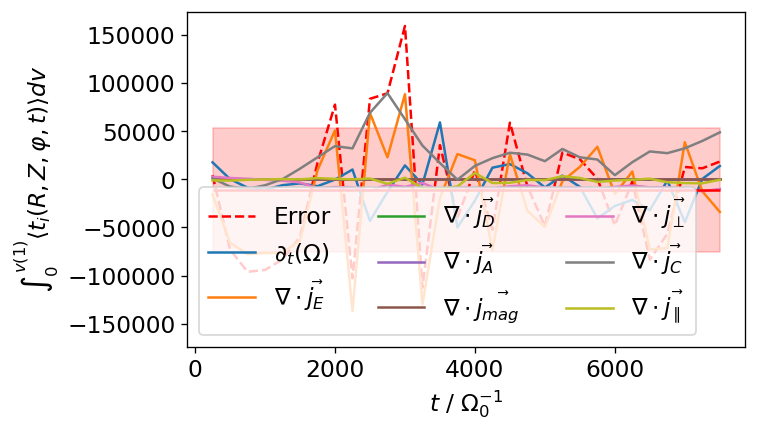

[1, 1]
Mean error is  57311.64095798824  std error is  252505.4867543946


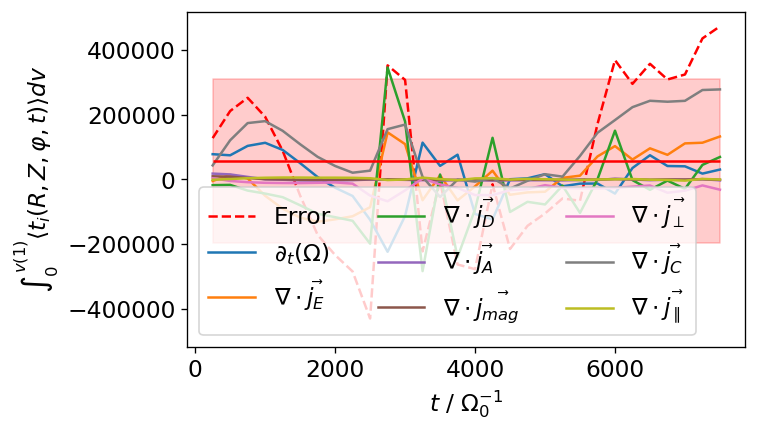

In [78]:
content_nn = [content[2],content[5]]
print( content_nn[0]["output"]["compression"])
make_to_plot(to_plot_coce,content_nn)
# for tau in [0,1]:
fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
tau = 0
res = 1e-4
plot_series(to_plot_coce,ax,tau,res)

plt.legend(ncol=3,loc='lower left')
plt.show()
# content_nn = [content[1]]
print( content_nn[0]["output"]["compression"])
make_to_plot(to_plot_coce,content_nn)
# for tau in [0,1]:
fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
tau = 1
res = 1e-4
plot_series(to_plot_coce,ax,tau,res)

plt.legend(ncol=3,loc='lower left')
plt.show()

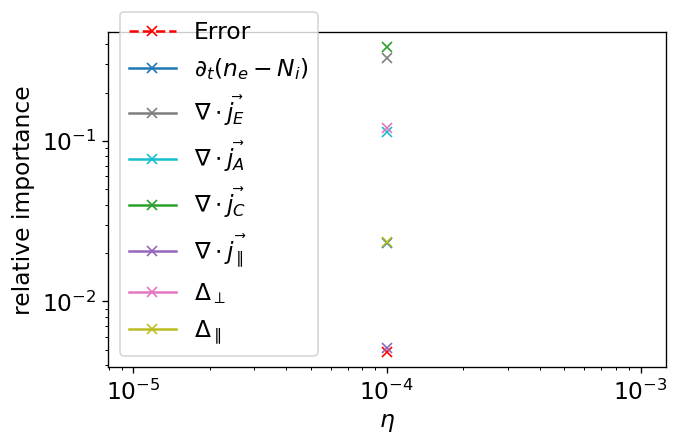

In [79]:
content_nn = [content3[0]]
make_to_plot(to_plot_coce,content_nn)
# more diffusion needed for tau=1 simulations?
# n_e - N_i not relevant for tau = 1 simulations?
for tau in [1]:
    fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
    plot_relative(to_plot_mass_diff,ax,tau,'log')
#     ax.set_yscale("linear")
    plt.legend(ncol=1,loc='lower left')


In [332]:
### THE TERMS IN THE MASS CONSERVATION
to_plot = {
    "tau" : [1], # taus
    "res": {0:[],1:[]}, # resistivities for taus
    "times": {0:dict(),1:dict()},
    "params" : {0:dict(),1:dict()}, # a copy of all parameters
    "fields" : [ # list of dicts
    {
        "names" : ["electrons_ifs_lcfs"], "derive" : True, "signs" : [+1],
#         "names" : ["ions_ifs_lcfs"], "derive" : True, "signs" : [+1],
        "color": 0,
        "label" : r"$\partial_t n_e$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['jvneE_tt_ifs_lcfs'], "derive" : False, "signs" : [+1],
#         "names" : ['jvniE_tt_ifs_lcfs'], "derive" : False, "signs" : [+1],
        "color": 1,
        "label" : r"$\nabla\cdot\vec{j_E}$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['jvneC_tt_ifs_lcfs'], "derive" : False, "signs" : [+1],
#         "names" : ['jvniC_tt_ifs_lcfs'], "derive" : False, "signs" : [+1],
        "color": 2,
        "label" : r"$\nabla\cdot\vec{j_C}$",
        "vals": {0:dict(),1:dict()},
    },
    {# small here but not in vorticity 
        "names" : ['jvneA_tt_ifs_lcfs'], "derive" : False, "signs" : [+1],
#         "names" : ['jvniA_tt_ifs_lcfs'], "derive" : False, "signs" : [+1],
        "color": 3,
        "label" :  r"$\nabla\cdot\vec{ j_A}$",
        "vals": {0:dict(),1:dict()},
    },
#     {
#         "names" : ['divjnepar_tt_ifs_lcfs'], "derive" : False, "signs" : [+1],
#         "color": 4,
#         "label" :  r"$\nabla \cdot \vec{ j_\parallel}$",
#         "vals": {0:dict(),1:dict()},
#     },
    {
        "names" : ['lneperp_tt_ifs_lcfs'], "derive" : False, "signs" : [-1],
#         "names" : ['lniperp_tt_ifs_lcfs'], "derive" : False, "signs" : [-1],
        # lniperp has a mistake in the feltordiag
        "color": 5,
        "label" :  r"$\Delta_\perp$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['lneparallel_tt_ifs_lcfs'], "derive" : False, "signs" : [-1],
        "color": 6,
        "label" :  r"$\Delta_\parallel$",
        "vals": {0:dict(),1:dict()},
    },
#     {
#         "names" : ['sne_tt_ifs_lcfs'], "derive" : False, "signs" : [-1],
# #         "names" : ['sni_tt_ifs_lcfs'], "derive" : False, "signs" : [-1],
#         "color": 7,
#         "label" :  r"$S_{n_e}$",
#         "vals": {0:dict(),1:dict()},
#     },
    ]
}



### Volume Integrated Mass conservation
The density equations directly yield the particle conservation
\begin{align} \label{eq:mass_theorem}
  \frac{\partial}{\partial t} N
  + \nabla\cdot\vec{ j_{N}}
  =  \Lambda_{N}+S_{N}
\end{align}
The terms of the particle conservation thus read
\begin{align}
  N= & N,\\
  \vec j_{N} =& N\left(
  \vec u_\psi + \vec u_C + \vec u_{K} +U_\parallel\left(\hat b+{\vec b}_\perp\right)  \right)
\label{eq:particle_flux}\\
  %\nonumber\\
  %=& N \left(\frac{\bhat\times \vn\phi}{B}
  %+ \tau_e \frac{\bhat\times\vn n_e}{n_eB}
  %+ \mu_e u_{\parallel,e}^2\vec K_{\vn\times\bhat}
  %+ u_{\parallel,e}(\bhat + {\vec b}_\perp) \right), \\
  \Lambda_{N} =& \Lambda_N
\\
  S_{N} =&  S_{N}
\end{align}

#### Volume integration yields
\begin{align}
  \frac{\partial}{\partial t} \int \langle N  \rangle dv
  + \langle \vec{ j_{N}}\cdot \nabla v \rangle
  =  \int \langle\Lambda_{N}+S_{N}\rangle dv
\end{align}
where $\langle f\rangle$ denotes the flux surface average (i.e. integration over the toroidal and poloidal
angle using the volume form)
#### Time integration yields
\begin{align}
  \frac{1}{\Delta T}\int \langle N(t_1) - N(t_0)  \rangle dv 
  + \frac{1}{\Delta T}\int_{t_0}^{t_1}\langle \vec{ j_{N}}\cdot \nabla v \rangle dt
  =   \frac{1}{\Delta T}\int_{t_0}^{t_1}\int \langle\Lambda_{N}+S_{N}\rangle dv dt
\end{align}
or the scalar equation
\begin{align}
    \frac{M(t_1) - M(t_0)}{\Delta T} + \bar J_M = \bar \Lambda_M + \bar S_M
\end{align}
where $\bar f \equiv \int_{t_0}^{t_t} \langle f\rangle dt / \Delta T$

### Relative accuracy and importance of terms

The above equation can be written in the form $\sum_i T_i = 0$ with
\begin{align}
  T_i := \frac{1}{\Delta T} \int_{t_0}^{t_1} \int_\Omega t_i(R,Z,\varphi,t) dV dt = \frac{1}{\Delta T} \int_{t_0}^{t_1} \int_0^{v(1)} \langle t_i(R,Z,\varphi,t)\rangle dv dt
\end{align}
However, due to numerical and / or analytical approximations we usually have
\begin{align}
\sum_i T_i = E
\end{align}
where $E$ is an error that is small compared to the $T_i$. In order to quantify the error term and the importance of any individual term $T_i$ in general we now introduce the importance
\begin{align}
W_i  :=& \frac{T_i}{ |E| + \sum_i |T_i| } \\
W_E :=& \frac{E }{|E| + \sum_i |T_i| }
\end{align}

If the individual terms $T_i$ fluctuate with standard deviation $\varepsilon_{T_i}$ we approximate
the fluctuation of the importance 
\begin{align}
    \varepsilon_{W_i} :=& \frac{\varepsilon_{T_i}}{ |E| + \sum_i |T_i| } \\
    \varepsilon_{W_E} :=& \frac{\varepsilon_{E} }{|E| + \sum_i |T_i| }
\end{align}
    

In [125]:
nn_content = [content2[0]]
make_to_plot(to_plot, nn_content)


Mean error is  75.87420804060667  std error is  123.37322301860124


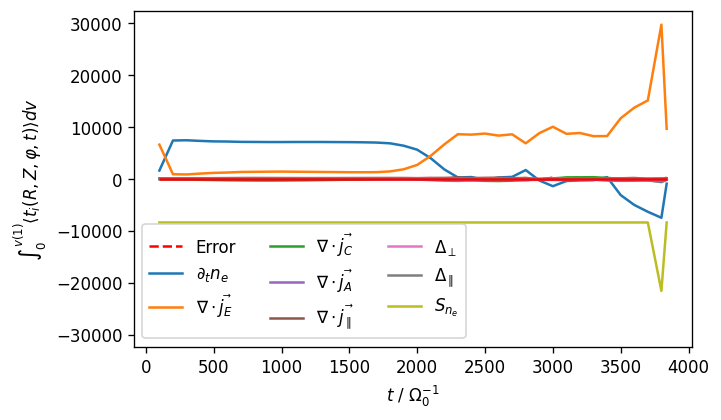

In [126]:

# for tau in [0,1]:
fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
tau = 1
res = 1e-4
plot_series(to_plot,ax,tau,res,start_idx=1)
#     ax.set_yscale("linear")


plt.legend(ncol=3,loc='lower left')
plt.show()

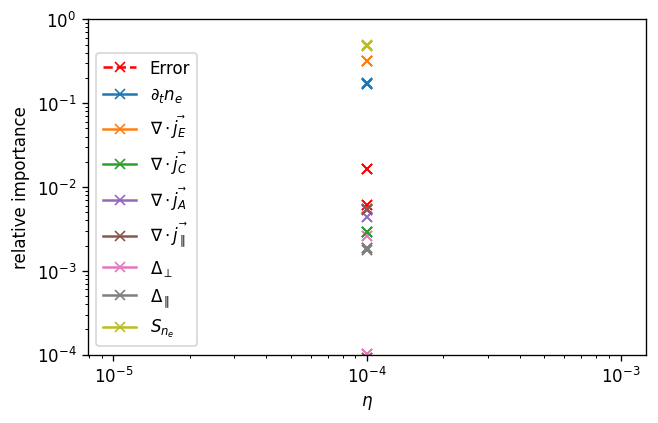

In [124]:
nn_content = [content[0]]
make_to_plot(to_plot, nn_content)
for tau in [1]:
    fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
    plot_relative(to_plot,ax,tau,'log')
#     ax.set_yscale("linear")
    plt.legend(ncol = 1, loc = 'lower left')
    plt.ylim([1e-4,1])
#     plt.savefig( 'ne-importance-'+str(tau)+'.png',bbox_inches='tight')
    
nn_content = [content[1]]
make_to_plot(to_plot, nn_content)
for tau in [1]:
#     fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
    plot_relative(to_plot,ax,tau,'log')
#     ax.set_yscale("linear")
#     plt.legend(ncol = 3, loc = 'lower center')
    plt.ylim([1e-4,1])
#     plt.savefig( 'ne-importance-'+str(tau)+'.png',bbox_inches='tight')
    plt.show()

In [65]:
### THE TERMS IN THE ENERGY CONSERVATION
to_plot_energy = {
    "tau" : [0,1], # taus
    "res": {0:[],1:[]}, # resistivities for taus
    "times": {0:dict(),1:dict()},
    "params" : {0:dict(),1:dict()}, # a copy of all parameters
    "fields" : [ # list of dicts
    {
        "names" : ["ue2_ifs_lcfs","nelnne_ifs_lcfs","nilnni_ifs_lcfs",
                   "neue2_ifs_lcfs","niui2_ifs_lcfs","aperp2_ifs_lcfs"],
        "derive" : True, "signs" : [+1,1,1,1,1,1],
        "color": 0,
        "label" : r"$\partial_t E$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['jvee_tt_ifs_lcfs','jvei_tt_ifs_lcfs','jveea_tt_ifs_lcfs','jveia_tt_ifs_lcfs'],
        "derive" : False, "signs" : [+1,1,1,1],
        "color": 1,
        "label" : r"$\nabla\cdot\vec{j_E}$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['leeperp_tt_ifs_lcfs','leiperp_tt_ifs_lcfs'], "derive" : False, "signs" : [-1,-1],
        "color": 2,
        "label" :  r"$\Delta_\perp$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['leeparallel_tt_ifs_lcfs','leiparallel_tt_ifs_lcfs'], "derive" : False, "signs" : [-1,-1],
        "color": 6,
        "label" :  r"$\Delta_\parallel$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['see_tt_ifs_lcfs','sei_tt_ifs_lcfs'], "derive" : False, "signs" : [-1,-1],
        "color": 7,
        "label" :  r"$S_{E}$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['resistivity_tt_ifs_lcfs'], "derive" : False, "signs" : [-1],
        "color": 8,
        "label" :  r"$R$",
        "vals": {0:dict(),1:dict()},
    }
    ]
}



TypeError: make_to_plot() missing 1 required positional argument: 'in_content'

Mean error is  -1671.538741812926  std error is  4235.70003454616


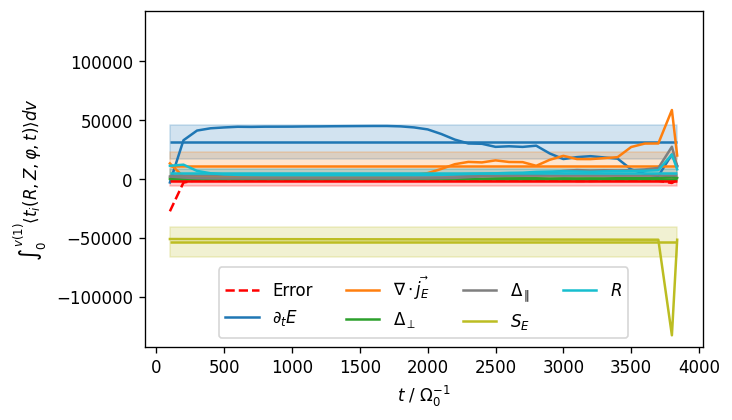

In [68]:
make_to_plot(to_plot_energy,nn_content)
# for tau in [0,1]:
fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
tau = 1
res = 1e-4
plot_series(to_plot_energy,ax,tau,res,start_idx=1)

plt.legend(ncol=4,loc='lower center')
plt.show()

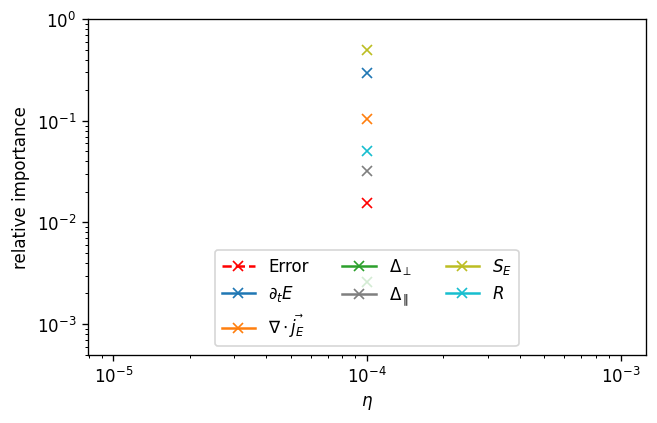

In [70]:
for tau in [1]:
    fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
    plot_relative(to_plot_energy,ax,tau,'log')
#     ax.set_yscale("linear")
    plt.legend(ncol = 3, loc = 'lower center')
    plt.ylim([5e-4,1])
    plt.show()

### Vorticity accuracy on LCFS

In [233]:
### THE TERMS IN THE VORTICITY CONSERVATION
# idx=167 #=lcfs
idx = 167
to_plot_vorticity = {
    "tau" : [0,1], # taus
    "res": {0:[],1:[]}, # resistivities for taus
    "times": {0:dict(),1:dict()},
    "params" : {0:dict(),1:dict()}, # a copy of all parameters
    "fields" : [ # list of dicts
    {
#         "names" : ['oexbe_fsa'], # bad for tau = 1
        "names" : ['oexbe_fsa','odiae_fsa'],
#     vorticity =np.asarray(da['oexbe_fsa'][:,:])
    # vorticity+=da['odiae_fsa'][:,:]
    # vorticity/=da['electrons_fsa'][:,:]
        "idx":idx, "derive" : True,"signs" : [+1,1],
        "color": 0,
        "label" : r"$\partial_t (\Omega_E + \Omega_D)$",
        "vals": {0:dict(),1:dict()},
    },
    {
#         "names" : ['jvoexbi_tt_ifs'],
        "names" : ['jvoexbe_tt_ifs'],
        "idx": idx,"derive" : False, "signs" : [+1],
        "color": 5,
        "label" : r"$\nabla\cdot\vec{j_\Omega,E}$",
        "vals": {0:dict(),1:dict()},
    },    
    {
#         "names" : ['jvoexbeUD_tt_ifs'], # bad for tau = 1
#         "names" : ['jvoexbiUD_tt_ifs'], # also quite bad
        "names" : ['jvodiaeUE_tt_ifs'],
#         "names" : ['jvodiaiUE_tt_ifs'], # above 10%
        "idx": idx,"derive" : False, "signs" : [+1],
        "color": 2,
        "label" : r"$\nabla\cdot\vec{ j_\Omega,D}$",
        "vals": {0:dict(),1:dict()},
    },  
    {
        "names" : ['jvoapar_tt_ifs'],
        "idx": idx,"derive" : False, "signs" : [+1],
        "color": 8,
        "label" : r"$Maxwell$",
        "vals": {0:dict(),1:dict()},
    },
#     {
# #         "names" : ['jvoexbApar_tt_ifs'],
#         "names" : ['jvodiaApar_tt_ifs'],
#         "idx": idx,"derive" : False, "signs" : [+1],
#         "color": 9,
#         "label" : r"$\nabla\cdot\vec{ j_{\Omega,D,A}}$",
#         "vals": {0:dict(),1:dict()},
#     },
#     {
#         "names" : ['loexbe_tt_fsa'],"idx":idx, "derive" : False, "sign" : -1,
#         "color": 1,
#         "label" :  r"$\Lambda$",
#         "vals": {0:dict(),1:dict()},
#     },
    {
        "names" : ['socurve_tt_fsa','socurvi_tt_fsa','socurvkappae_tt_fsa','socurvkappai_tt_fsa'],
#     # force2 = -da["curvne_tt_ifs"][:,:]/deltat[:,None]/dvdpsi[:]
        "idx":idx, "derive" : False, "signs" : [-1,-1,-1,-1],
        "color": 6,
        "label" :  r"$Force$",
        "vals": {0:dict(),1:dict()},
    }
#     {
#         "names" : [''], "derive" : False, "sign" : -1,
#     # source = da["sosne_tt_fsa"][:,:]/deltat[:,None]
#     # source+= da["sospi_tt_fsa"][:,:]/deltat[:,None]
#         "color": 7,
#         "label" :  r"$S_{E}$",
#         "vals": {0:dict(),1:dict()},
#     },
    ]
}


Mean error is  -1.2510001540960926e-05  std error is  9.436093259755447e-06


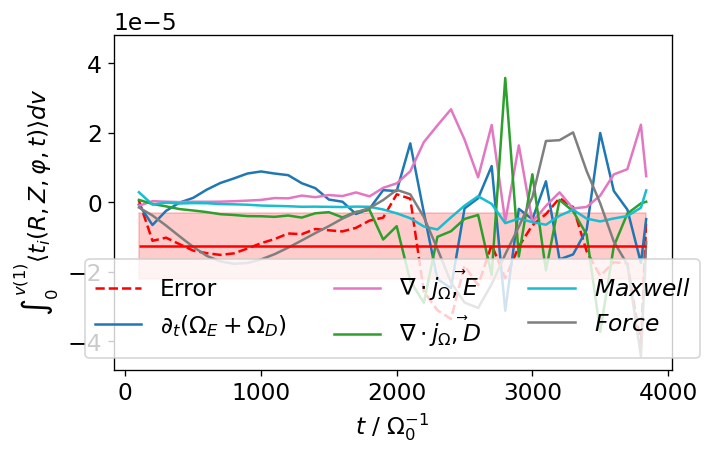

In [236]:

make_to_plot(to_plot_vorticity,[content3[0]])
# for tau in [0,1]:
fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
tau = 1
res = 1e-4
plot_series(to_plot_vorticity,ax,tau,res)

plt.legend(ncol=3,loc='lower center')
plt.show()

<ipython-input-117-aa1ff41a1ecc>:63: RuntimeWarning: Mean of empty slice.
  if(mean[field["label"]].mean() != 0):


ValueError: Data has no positive values, and therefore can not be log-scaled.

<Figure size 720x444 with 1 Axes>

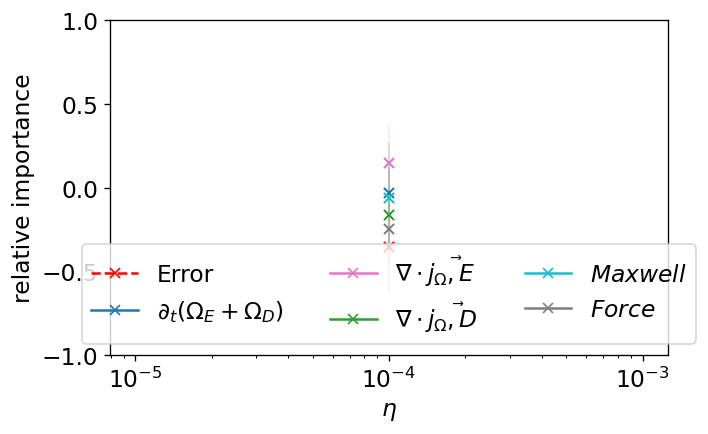

In [239]:
for tau in [0,1]:
    fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
    plot_relative(to_plot_vorticity,ax,tau,'linear')
#     ax.set_yscale("linear")
#     plt.legend()
    plt.legend( ncol=3, loc='lower center'#, bbox_to_anchor=(0.5, 1.05),
         )#, fancybox=True, shadow=True)
    ax.set_ylim([-1,1])
    plt.show()

## Ion parallel momentum

In [248]:
### THE TERMS IN THE TOROIDAL MOMENTUM
to_plot_momentum = {
    "tau" : [0,1], # taus
    "res": {0:[],1:[]}, # resistivities for taus
    "times": {0:dict(),1:dict()},
    "params" : {0:dict(),1:dict()}, # a copy of all parameters
    "fields" : [ # list of dicts
    {
        "names" : ["niui_ifs_lcfs"], "derive" : [True], "signs" : [+1],
        "color": 0,
        "label" : r"$\partial_t N_iU_{\parallel,i}$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['jvparexbi_tt_ifs_lcfs'],
        "derive" : [False], "signs" : [1],
        "color": 1,
        "label" : r"$\nabla\cdot(\vec{j_E})$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['jvparApar_tt_ifs_lcfs'],
        "derive" : [False], "signs" : [1],
        "color": 2,
        "label" : r"$\nabla\cdot(\vec{j_A})$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['jvpardiai_tt_ifs_lcfs'],
        "derive" : [False], "signs" : [1],
        "color": 3,
        "label" : r"$\nabla\cdot(\vec{j_D})$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['jvparkappai_tt_ifs_lcfs'],
        "derive" : [False], "signs" : [1],
        "color": 4,
        "label" : r"$\nabla\cdot(\vec{j_K})$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ["sparmirrori_tt_ifs_lcfs",'sparmirrore_tt_ifs_lcfs'],
        "derive" : [False,False], "signs" : [-1,-1],
        "color": 5,
        "label" : r"$\nabla_\parallel(n_e + N_i)$",
        "vals": {0:dict(),1:dict()},
    },

#     divjpar = np.asarray(da['divjpare_tt_ifs_lcfs'][:])/deltat
#     divjpar += np.asarray(da['divjpari_tt_ifs_lcfs'][:])/deltat
#     { # is zero
#         "names" : ['sparsni_tt_ifs_lcfs'], "derive" : False, "signs" : [-1],
#         "color": 4,
#         "label" : r"$S$",
#         "vals": {0:dict(),1:dict()},
#     },
#     { # works better without
#         "names" : ['sparmirrorAe_tt_ifs_lcfs','sparmirrorAi_tt_ifs_lcfs'],
#         "derive" : [False,False], "signs" : [-1,-1],
#         "color": 7,
#         "label" : r"$Mirror_A$",
#         "vals": {0:dict(),1:dict()},
#     },    
#     {
#         "names" : ['sparphii_tt_ifs_lcfs',"sparphiAi_tt_ifs_lcfs",'friction_tt_ifs_lcfs','spardotAi_tt_ifs_lcfs'],
#         "derive" : [False,False,False,False], "signs" : [-1,-1,+1,-1],
#         "color": 8,
#         "label" : r"$-N_i\nabla_\parallel \phi_i + R + dot A$",
#         "vals": {0:dict(),1:dict()},
#     }, # can be replaced by:
#     {
#         "names" : ['spardotAi_tt_ifs_lcfs'],
#         "derive" : [False], "signs" : [-1],
#         "color": 1,
#         "label" : r"$A dot$",
#         "vals": {0:dict(),1:dict()},
#     },
    ]
}



Mean error is  15664.178100844729  std error is  29270.503202309592


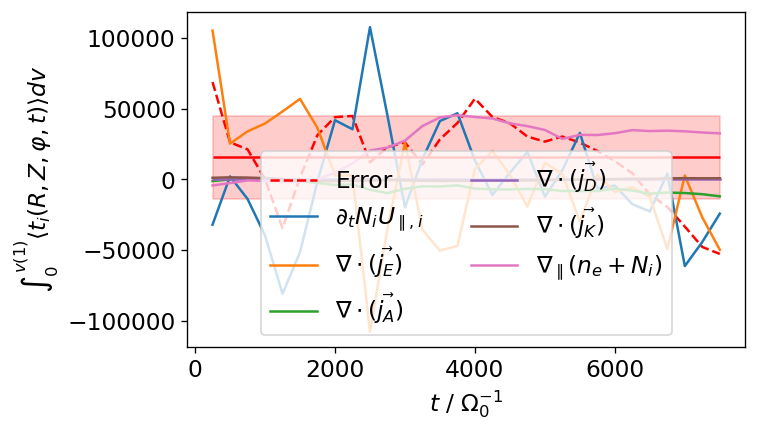

In [249]:
content_nn = [content[2],content[5]]
make_to_plot(to_plot_momentum, content_nn)
# for tau in [0,1]:
fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
tau = 0
res = 1e-4
plot_series(to_plot_momentum,ax,tau,res,start_idx=1)

plt.legend(ncol = 2, loc = 'lower center')
plt.show()

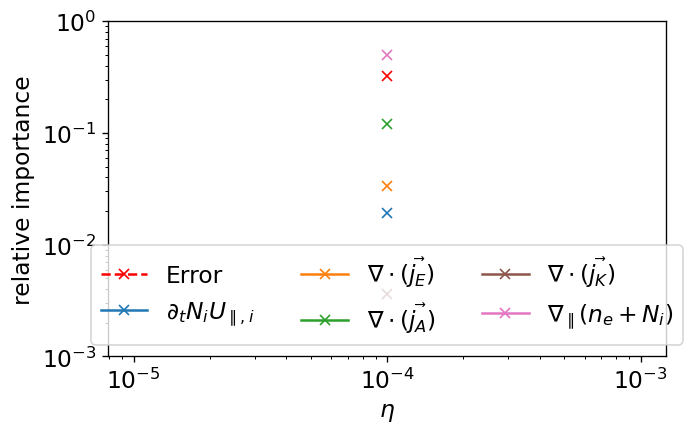

In [250]:
for tau in [0]:
    fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
    
    plot_relative(to_plot_momentum,ax,tau,'log')
#     ax.set_yscale("linear")
    plt.legend(ncol = 3, loc = 'lower center')
    plt.ylim([1e-3,1])
    plt.show()

## Parallel electron force balance

In [215]:
### THE TERMS IN THE PARALLEL ELECTRON FORCE BALANCE
to_plot_electron_force = {
    "tau" : [0,1], # taus
    "res": {0:[],1:[]}, # resistivities for taus
    "times": {0:dict(),1:dict()},
    "params" : {0:dict(),1:dict()}, # a copy of all parameters
    "fields" : [ # list of dicts
    {
        "names" : ['sparmirrore_tt_ifs_lcfs'],
        "derive" : [False], "signs" : [1],
        "color": 5,
        "label" : r"$Mirror$",
        "vals": {0:dict(),1:dict()},
    },
#     {
#         "names" : ['friction_tt_ifs_lcfs'],
#         "derive" : [False], "signs" : [1],
#         "color": 2,
#         "label" : r"$\eta$",
#         "vals": {0:dict(),1:dict()},
#     },
    {
        "names" : ['sparphie_tt_ifs_lcfs','friction_tt_ifs_lcfs'],
        "derive" : [False,False], "signs" : [1,1],
        "color": 3,
        "label" : r"$n_e\nabla_\parallel\phi + R$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['sparphiAe_tt_ifs_lcfs'],
        "derive" : [False], "signs" : [1],
        "color": 4,
        "label" : r"$n_e\nabla_{A,\parallel}\phi$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['spardotAe_tt_ifs_lcfs'],
        "derive" : [False], "signs" : [1],
        "color": 8,
        "label" : r"$n_e\partial_t A_\parallel$",
        "vals": {0:dict(),1:dict()},
    },
#     { # it works better without ...
#         "names" : ['sparmirrorAe_tt_ifs_lcfs'], "derive" : [False], "signs" : [+1],
#         "color": 7,
#         "label" : r"$Mirror_A$",
#         "vals": {0:dict(),1:dict()},
#     },
    ]
}


Mean error is  -24491.963912739244  std error is  8734.466595218828


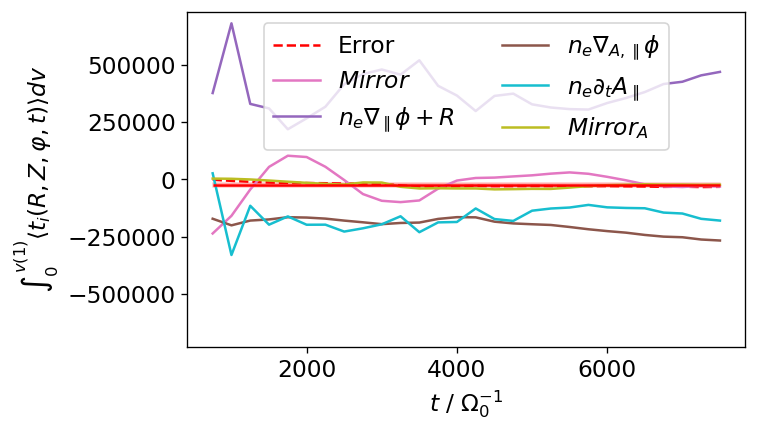

In [216]:
# for tau in [0,1]:
content_nn = [content[2],content[5]]
make_to_plot(to_plot_electron_force,content_nn)
fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
tau = 1
res = 1e-4
plot_series(to_plot_electron_force,ax,tau,res,start_idx=3)
low, high = ax.get_ylim()
bound = 4000# max(abs(low), abs(high))
# ax.set_ylim(-bound, bound)
# ax.set_xlim(1000,100000)
plt.legend(ncol = 2, loc='upper center')
plt.show()

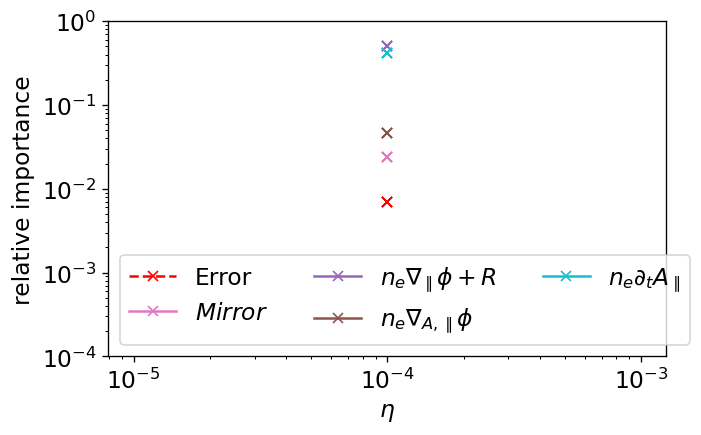

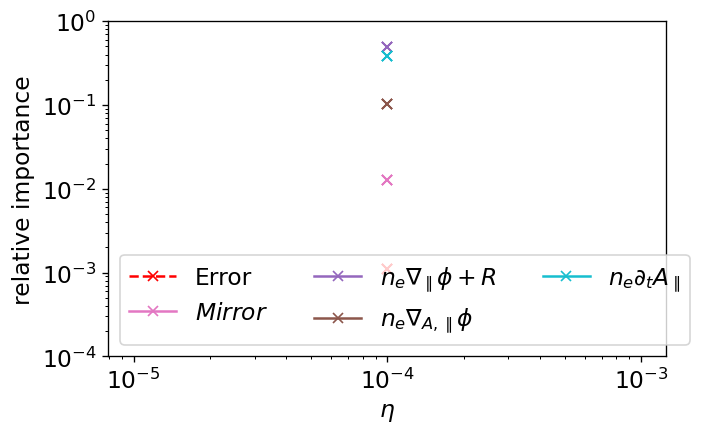

In [214]:
for tau in [0,1]:
    fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
    
    plot_relative(to_plot_electron_force,ax,tau,'log')
#     ax.set_yscale("linear")
    plt.legend(ncol=3, loc = 'lower left')
    plt.ylim([1e-4,1])
    plt.show()

In [194]:
### TEST if ion and electron force terms are small against the parallel pressure gradient
to_plot_electron_force_diff = {
    "tau" : [0,1], # taus
    "res": {0:[],1:[]}, # resistivities for taus
    "times": {0:dict(),1:dict()},
    "params" : {0:dict(),1:dict()}, # a copy of all parameters
    "fields" : [ # list of dicts
#     {
#         "names" : ['sparmirrore_tt_ifs_lcfs'],
#         "derive" : [False], "signs" : [1],
#         "color": 5,
#         "label" : r"$Mirror$",
#         "vals": {0:dict(),1:dict()},
#     },
#     {
#         "names" : ['friction_tt_ifs_lcfs'],
#         "derive" : [False], "signs" : [1],
#         "color": 2,
#         "label" : r"$\eta$",
#         "vals": {0:dict(),1:dict()},
#     },
    {
        "names" : ['sparphie_tt_ifs_lcfs','sparphii_tt_ifs_lcfs'],
        "derive" : [False,False], "signs" : [1,1],
        "color": 3,
        "label" : r"$\delta N\nabla_\parallel\phi $",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['sparphiAe_tt_ifs_lcfs','sparphiAi_tt_ifs_lcfs'],
        "derive" : [False,False], "signs" : [1,1],
        "color": 4,
        "label" : r"$\delta N \nabla_{A,\parallel}\phi$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['spardotAe_tt_ifs_lcfs','spardotAi_tt_ifs_lcfs'],
        "derive" : [False,False], "signs" : [1,1],
        "color": 8,
        "label" : r"$\delta N\partial_t A_\parallel$",
        "vals": {0:dict(),1:dict()},
    },
#     { # it works better without ...
#         "names" : ['sparmirrorAe_tt_ifs_lcfs'],
#         "derive" : [False], "signs" : [+1],
#         "color": 7,
#         "label" : r"$Mirror_A$",
#         "vals": {0:dict(),1:dict()},
#     },
    ]
}


Mean error is  2672.7710771034713  std error is  2150.1111007212553


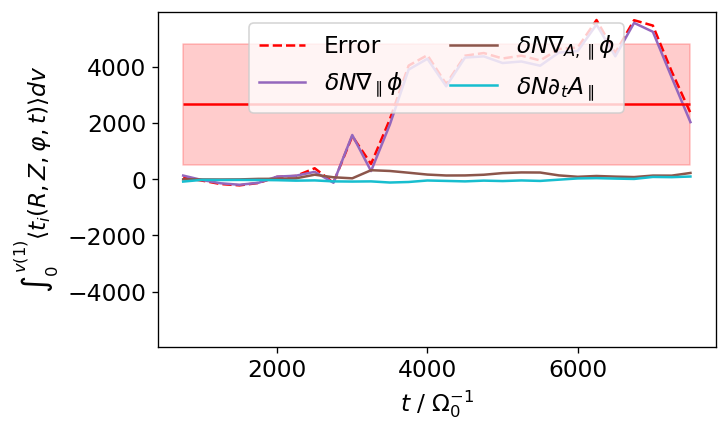

In [195]:
# for tau in [0,1]:
content_nn = [content[2],content[5]]
make_to_plot(to_plot_electron_force_diff,content_nn)
fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
tau = 0
res = 1e-4
plot_series(to_plot_electron_force_diff,ax,tau,res,start_idx=3)
low, high = ax.get_ylim()
bound = 4000# max(abs(low), abs(high))
# ax.set_ylim(-bound, bound)
# ax.set_xlim(1000,100000)
plt.legend(ncol = 2, loc='upper center')
plt.show()